In [1]:
import numpy              as np
import networkx           as nx
import seaborn            as sns
import matplotlib.pyplot  as plt
import random
import time
import datetime
import os
from   math               import ceil

from   experiments.group_level_experiments_unseen import calculate_nx_ppr_from_R

from   utils.recwalk_funcs              import create_recwalk_model, create_recwalk_model_from_adj
from   utils.counterfactual             import ppr_absorbing_2_item_side
from   model.user_item_dataset          import UserItemDataset
from   misc.dataset_stats               import plot_statistics

In [2]:
# PLOTTING CONFIGURATIONS
# enable inline plotting
%matplotlib inline
%config InlineBackend.figure_format = 'svg' # set format to svg for better resolution
sns.set_theme() # apply default theme in seaborn

# Dataset loading

Male to Action: 0.6224642563066097
Female to Romance: 0.523059866962306


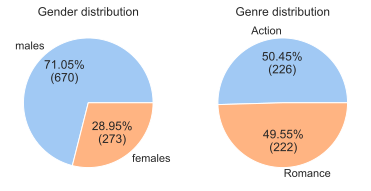

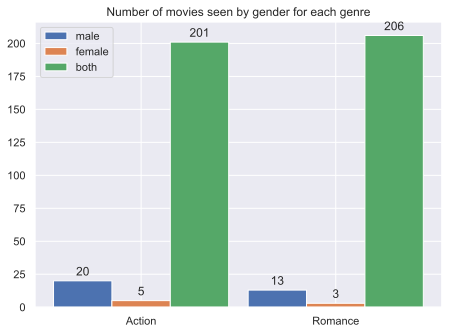

In [3]:
# Load dataset
my_dataset = UserItemDataset()
my_dataset.load_data(info_filepath='../datasets/ml-100k/u.info',
                     users_filepath='../datasets/ml-100k/u.user',
                     items_filepath='../datasets/ml-100k/u.item',
                     genres_filepath='../datasets/ml-100k/u.genre',
                     ratings_filepath='../datasets/ml-100k/u.data')

# my_dataset = UserItemDataset()
# my_dataset.load_data(info_filepath='../datasets/small_dataset_custom/u.info',
#                      users_filepath='../datasets/small_dataset_custom/u.user',
#                      items_filepath='../datasets/small_dataset_custom/u.item',
#                      genres_filepath='../datasets/small_dataset_custom/u.genre',
#                      ratings_filepath='../datasets/small_dataset_custom/u.data')


# Define genres of interest (I_0 and I_1)
genres_of_interest = ['Action', 'Romance']

# Note: i-th element of array user_original_ids corresponds to the real user-id (from 0 to n-1)
#       of user in i-th row of array R
user_original_ids, item_original_ids, R = my_dataset.filter_interactions_by_genre(genres_of_interest,
                                                                                  exclusive=True)
users_num, items_num = R.shape[0], R.shape[1]

# Find male/female user mapped ids
male_mapped_ids = np.array([i for i in range(users_num) if my_dataset.is_male(user_original_ids[i])])
female_mapped_ids = np.array([i for i in range(users_num) if not my_dataset.is_male(user_original_ids[i])])

# Seperate item group mapped ids for group 0 and group 1
item_group_mapped_ids_0, item_group_mapped_ids_1 = [], []
for i in range(item_original_ids.shape[0]): # TODO: Change item_original_ids.shape[0] to items_num
    if my_dataset.is_genre(item_original_ids[i], genres_of_interest[0]):
        item_group_mapped_ids_0.append(i)
    else:
        item_group_mapped_ids_1.append(i)

# Transform to numpy arrays
item_group_mapped_ids_0, item_group_mapped_ids_1 = np.array(item_group_mapped_ids_0), np.array(item_group_mapped_ids_1)

# Plot statistics about the subset of dataset
plot_statistics(dataset=my_dataset,
                genres=genres_of_interest,
                user_original_ids=user_original_ids,
                item_original_ids=item_original_ids,
                R=R)

In [4]:
def calculate_matrix_Q(P, gamma=0.15):
    return gamma*np.linalg.inv((np.identity(P.shape[0]) - (1-gamma)*P))

# Individual-level

---

## Filter items

In [5]:
# Filter items to have at least one rating from each gender and at least 10 ratings overall
filtered_item_ids = np.nonzero((np.count_nonzero(R[male_mapped_ids, :], axis = 0) >= 1) &
                               (np.count_nonzero(R[female_mapped_ids, :], axis = 0) >= 1) &
                               (np.count_nonzero(R, axis=0) >= 10))[0]

print(f"#item with >= 1 rating from both genders and >= 10 ratings overall: {filtered_item_ids.shape[0]}/{items_num}")
print(f"Action: {np.count_nonzero(np.in1d(filtered_item_ids, item_group_mapped_ids_0))}/{item_group_mapped_ids_0.shape[0]}")
print(f"Romance: {np.count_nonzero(np.in1d(filtered_item_ids, item_group_mapped_ids_1))}/{item_group_mapped_ids_1.shape[0]}")

#item with >= 1 rating from both genders and >= 10 ratings overall: 347/448
Action: 181/226
Romance: 166/222


## Filter users

In [25]:
male_mapped_ids_filtered = male_mapped_ids[
                            np.nonzero((np.count_nonzero(R[male_mapped_ids[:, np.newaxis], item_group_mapped_ids_0],
                                                                                                      axis=1) >= 1) &
                                       (np.count_nonzero(R[male_mapped_ids[:, np.newaxis], item_group_mapped_ids_1],
                                                                                                      axis=1) >= 1))]

female_mapped_ids_filtered = female_mapped_ids[
                            np.nonzero((np.count_nonzero(R[female_mapped_ids[:, np.newaxis], item_group_mapped_ids_0],
                                                                                                        axis=1) >= 1) &
                                       (np.count_nonzero(R[female_mapped_ids[:, np.newaxis], item_group_mapped_ids_1],
                                                                                                        axis=1) >= 1))]

print(male_mapped_ids_filtered.shape)
print(female_mapped_ids_filtered.shape)

(650,)
(266,)


### Calculate alpha and beta for items

*To choose items i calculate following:*
1. For each item i:
    - Calculate $a = \frac{r_{U_0}(i)/size({U_0})}{r_{U_1}(i)/size({U_1})}$
    - Calculate $\beta = p_{U_0}(i)/p_{U_1}(i)$, for $u \in (U_0 \cup U_1)$ 

In [6]:
# Calculate alpha
# Note: np.mean() can be used only because R is binary
alpha = np.mean(R[male_mapped_ids[:, np.newaxis], filtered_item_ids], axis=0)/(
        np.mean(R[female_mapped_ids[:, np.newaxis], filtered_item_ids], axis=0))

P = create_recwalk_model(R)
Q_u_to_i = calculate_matrix_Q(P)[:users_num, users_num:]

# Calculate beta
beta = []
for item_i in filtered_item_ids:
    p_U_0_i = np.mean(Q_u_to_i[male_mapped_ids, item_i])
    p_U_1_i = np.mean(Q_u_to_i[female_mapped_ids, item_i])
    beta.append(p_U_0_i/p_U_1_i)
beta = np.array(beta)

## Experiment 1

* Remove *from* users *to* items x != i, choosing items x by: $\Delta_{avg}(u, i, (u, x))$ for $u \in U_0$

In [32]:
# Parameters
sample_size = 5
epsilon = 0.05

# alpha_inds = np.where((alpha >= 0.9) & (alpha <= 1.1))[0] # 50/50
# alpha_inds = np.where((alpha >= (1.5 - epsilon)) & (alpha <= (1.5 + epsilon)))[0] # 60/40
# sample_item_i_ids = filtered_item_ids[alpha_inds[np.argsort(beta[alpha_inds])]][:sample_size]

# beta_inds = np.where((alpha >= beta) & (beta >= 0.7) & (beta <= 0.8))[0]# &
# #                      (np.sum(R[:, filtered_item_ids], axis=0) >= 35)  )[0]
# sample_item_i_ids = filtered_item_ids[beta_inds[np.argsort(beta[beta_inds])]][:sample_size]

alpha_inds = np.where((alpha >= 0.9) & (alpha <= 1.1))[0] # 50/50
sample_item_i_ids = filtered_item_ids[alpha_inds[np.argsort(beta[alpha_inds])]][:sample_size]

for sample_item_i in sample_item_i_ids:
    ind = np.where(filtered_item_ids == sample_item_i)[0][0]
    print(f"Original id: {item_original_ids[sample_item_i]}")
    print(f"alpha={alpha[ind]}, beta={beta[ind]}")
    print(f"r_males={np.count_nonzero(R[male_mapped_ids, sample_item_i])}" +  
          f",r_females={np.count_nonzero(R[female_mapped_ids, sample_item_i])}")
    print('----')

Original id: 880
alpha=0.9022388059701493, beta=0.6753385859462434
r_males=31,r_females=14
----
Original id: 875
alpha=1.0656716417910448, beta=0.695954429539769
r_males=34,r_females=13
----
Original id: 338
alpha=0.96044776119403, beta=0.7357794710022344
r_males=33,r_females=14
----
Original id: 1104
alpha=1.0594029850746267, beta=0.7382741864687423
r_males=13,r_females=5
----
Original id: 688
alpha=0.9054726368159204, beta=0.7880277426124623
r_males=60,r_females=27
----


In [29]:
# Parameters
num_x_to_remove = 30
export_dir_path = "./output/full/individual_item_side/exp1"
export_filename = f"exp1_{sample_size}_{num_x_to_remove}_a_1"

# with open(f"{export_dir_path}/{export_filename}_details.tsv", 'w') as f:
#     f.write('item_id\tr_star_U_0\tr_star_U_1\talpha\tbeta\n')
#     for sample_item_i in sample_item_i_ids:
#         ind = np.where(filtered_item_ids == sample_item_i)[0][0]
#         f.write(f"{item_original_ids[sample_item_i]}\t")
#         f.write(f"{np.count_nonzero(R[male_mapped_ids, sample_item_i])/male_mapped_ids.shape[0]}\t")
#         f.write(f"{np.count_nonzero(R[female_mapped_ids, sample_item_i])/female_mapped_ids.shape[0]}\t")
#         f.write(f"{alpha[ind]}\t{beta[ind]}")
        
#         if sample_item_i != sample_item_i_ids[-1]: f.write('\n')

print(f"Sample item original ids: {item_original_ids[sample_item_i_ids]}")

individual_item_side_avg_delta(R=R,
                               user_original_ids = user_original_ids,
                               item_original_ids = item_original_ids,
                               sample_item_i_ids = sample_item_i_ids,
                               item_ids_all      = filtered_item_ids,
                               u_ids_0           = male_mapped_ids,
                               u_ids_1           = female_mapped_ids,
                               num_x_to_remove   = num_x_to_remove,
                               compute_avg       = False,
                               choose_by_delta   = True,
                               export_dir_path   = export_dir_path,
                               export_filename   = export_filename)

Sample item original ids: [ 880  875  338 1104  688]
[2023-04-02 11:09:29.511319] Item 1 - id: 880
[2023-04-02 11:09:29.513306] Total items x: 346
Counter: 20
[2023-04-02 11:10:21.676531] Item 2 - id: 875
[2023-04-02 11:10:21.677530] Total items x: 346
Counter: 20
[2023-04-02 11:11:17.985542] Item 3 - id: 338
[2023-04-02 11:11:17.987541] Total items x: 346
Counter: 20
[2023-04-02 11:12:15.991822] Item 4 - id: 1104
[2023-04-02 11:12:15.994821] Total items x: 346
Counter: 20
[2023-04-02 11:13:13.424860] Item 5 - id: 688
[2023-04-02 11:13:13.425859] Total items x: 346
Counter: 20
Wall time: 4.7191 minutes


In [16]:
# Experiment for qualitative
sample_item_i_ids = np.array([121, 283, 119, 122, 301, 332, 314])
export_dir_path = './output/full/individual_item_side/qualitative'
export_filename = './indiv_i_side_qual_1'
individual_item_side_avg_delta(R=R,
                               user_original_ids=user_original_ids,
                               item_original_ids=item_original_ids,
                               sample_item_i_ids=sample_item_i_ids,
                               item_ids_all=filtered_item_ids,
                               u_ids_0=male_mapped_ids,
                               u_ids_1=female_mapped_ids,
                               num_x_to_remove=20,
                               export_dir_path=export_dir_path,
                               export_filename=export_filename)

[2023-03-27 15:19:18.799050] Item 1 - id: 348
[2023-03-27 15:19:18.919982] Total items x: 346
Counter: 20
[2023-03-27 15:19:50.445355] Item 2 - id: 880
[2023-03-27 15:19:50.569321] Total items x: 346
Counter: 20
[2023-03-27 15:20:26.977722] Item 3 - id: 338
[2023-03-27 15:20:27.062642] Total items x: 346
Counter: 20
[2023-03-27 15:21:06.085576] Item 4 - id: 349
[2023-03-27 15:21:06.196545] Total items x: 346
Counter: 20
[2023-03-27 15:21:37.742105] Item 5 - id: 947
[2023-03-27 15:21:37.848044] Total items x: 346
Counter: 20
[2023-03-27 15:22:12.083101] Item 6 - id: 1109
[2023-03-27 15:22:12.121081] Total items x: 346
Counter: 20
[2023-03-27 15:22:37.602318] Item 7 - id: 1024
[2023-03-27 15:22:37.706261] Total items x: 346
Counter: 20
Wall time: 3.9514 minutes


In [12]:
def individual_item_side_avg_delta(R,
                                   user_original_ids,
                                   item_original_ids,
                                   sample_item_i_ids,
                                   item_ids_all,
                                   u_ids_0,
                                   u_ids_1,
                                   num_x_to_remove=-1,
                                   compute_avg=True,
                                   choose_by_delta=True,
                                   export_dir_path=None,
                                   export_filename=None,
                                   export_results=True):
    users_num, items_num = R.shape[0], R.shape[1]
    
    p_U_0_to_i_initial_all, p_U_1_to_i_initial_all = [], []
    p_U_0_to_i_new_all, p_U_1_to_i_new_all = [], []
    item_x_ids_removed_all = []
    deltas_0_all = []
    
    P = create_recwalk_model(R) # Create transition prob. matrix
    Q_mat = calculate_matrix_Q(P)
    ppr_u_to_i = Q_mat[:users_num, users_num:] # From Q, keep users to items scores part
    ppr_u_to_u = Q_mat[:users_num, :users_num]
    ppr_i = Q_mat[users_num:, :]
    
    item_cnt = 0
    # Keep time started
    start_wall_t = time.time()
    for item_i_id in sample_item_i_ids:
        print(f"[{datetime.datetime.now()}] Item {item_cnt + 1} - id: {item_original_ids[item_i_id]}")
        
        p_U_0_to_i_initial_all.append(np.mean(ppr_u_to_i[u_ids_0, item_i_id]))
        p_U_1_to_i_initial_all.append(np.mean(ppr_u_to_i[u_ids_1, item_i_id]))
        
        item_x_ids = np.setdiff1d(item_ids_all, item_i_id) # All items except for item i
        
        print(f"[{datetime.datetime.now()}] Total items x: {item_x_ids.shape[0]}")
        items_to_remove = []
        deltas_0, deltas_1 = [], []
        for cur_item_id in item_x_ids:
            cur_nbs_in_U_0 = np.intersect1d(np.nonzero(R[:, cur_item_id])[0], u_ids_0)
            
            d_0, d_1 = 0, 0
            for u_id in cur_nbs_in_U_0:
                # Same term 1, different term 2
                d_0_term_1 = np.mean(ppr_u_to_u[u_ids_0, u_id])
                d_1_term_1 = np.mean(ppr_u_to_u[u_ids_1, u_id])
                
                d_term_2 = calculate_lambda_item_side(scores=ppr_i,
                                                      x_param=u_id,
                                                      i_param=item_i_id+users_num,
                                                      S_x=np.array([cur_item_id]),
                                                      R_x=np.nonzero(R[u_id])[0])
                
                d_0 += d_0_term_1*d_term_2
                d_1 += d_1_term_1*d_term_2
                        
            if d_0 <= 0: continue
    
            items_to_remove.append(cur_item_id)
    
            if compute_avg: d_0 /= cur_nbs_in_U_0.shape[0]; d_1 /= cur_nbs_in_U_0.shape[0]
            deltas_0.append(d_0)
            deltas_1.append(d_1)

        if choose_by_delta: # Choose by delta
            sort_inds = np.argsort(deltas_0)[::-1][:num_x_to_remove] if num_x_to_remove > 0 else np.argsort(deltas_0)[::-1]
        else: # Choose by greatest difference
            diff = np.array(deltas_0) - np.array(deltas_1)
            sort_inds = np.argsort(diff)[::-1][:num_to_remove] if num_to_remove > 0 else np.argsort(diff)[::-1]
            
        # Create adjacency matrix
        adj_mat = np.zeros((users_num + items_num, users_num + items_num), dtype=int)
        adj_mat[:users_num, users_num:] = R
        adj_mat[users_num:, :users_num] = R.T
                
        p_U_0_to_i_new_cur, p_U_1_to_i_new_cur = [], []
        for ind in sort_inds:            
            cur_nbs_in_U_0 = np.intersect1d(np.nonzero(R[:, items_to_remove[ind]])[0], u_ids_0)
            
            adj_mat[cur_nbs_in_U_0, users_num + items_to_remove[ind]] = 0 # Remove user->item edges
    
            if (~adj_mat[cur_nbs_in_U_0, :].any(axis=1)).any(): # Check if there are 0 rows
                zero_row_inds = np.where(~adj_mat[cur_nbs_in_U_0, :].any(axis=1))[0]
                
                # Keep one neighbor for each zero row
                for zero_ind in zero_row_inds:
                    adj_mat[cur_nbs_in_U_0[zero_ind], users_num + items_to_remove[ind]] = 1

            P = create_recwalk_model_from_adj(adj_mat)
            ppr_u_to_i_new = calculate_matrix_Q(P)[:users_num, users_num:]
            
            p_U_0_to_i_new_cur.append(np.mean(ppr_u_to_i_new[u_ids_0, item_i_id]))
            p_U_1_to_i_new_cur.append(np.mean(ppr_u_to_i_new[u_ids_1, item_i_id]))
            
            if (np.where(sort_inds == ind)[0][0] + 1) % 20 == 0: print(f"Counter: {np.where(sort_inds == ind)[0][0] + 1}")
        
        deltas_0_all.append(np.array(deltas_0)[sort_inds])
        p_U_0_to_i_new_all.append(p_U_0_to_i_new_cur)
        p_U_1_to_i_new_all.append(p_U_1_to_i_new_cur)
        item_x_ids_removed_all.append(np.array(items_to_remove)[sort_inds])
        
        item_cnt += 1
        
    # Keep time ended
    end_wall_t = time.time()
    print(f"Wall time: {round((end_wall_t-start_wall_t)/60, 4)} minutes")
    
    # Modify export filename depending on choices
    export_filename += '_avg' if compute_avg else '_sum'
    export_filename += '_delta' if choose_by_delta else '_diff'
        
    ##### EXPORT RESULTS TO FILE #####
    if export_results:
        file_exists = os.path.exists(f"{export_dir_path}/{export_filename}.tsv")
        with open(f"{export_dir_path}/{export_filename}.tsv", 'a') as f:
            if not file_exists:
                # Write header
                f.write("#File format (per 6 lines):\n")
                f.write("#<Item_id_i>\n")
                f.write("#<Group_0_initial_PPR> <Group_1_initial_PPR>\n")
                f.write("#<Group_0_delta_0> <Group_0_delta_1> [...] <Group_0_delta_n>\n")
                f.write("#<Group_0_new_PPR_0> <Group_0_new_PPR_1> [...] <Group_0_new_PPR_n>\n")
                f.write("#<Group_1_new_PPR_0> <Group_1_new_PPR_1> [...] <Group_1_new_PPR_n>\n")
                f.write("#<item_id_x_removed_0> <item_id_x_removed_1> [...] <item_id_x_removed_n>\n")
            else:
                f.write('\n')
            
            # Write results
            for i in range(sample_item_i_ids.shape[0]):
                item_original_id_cur = item_original_ids[sample_item_i_ids[i]]
                p_U_0_to_i_initial = p_U_0_to_i_initial_all[i]
                p_U_1_to_i_initial = p_U_1_to_i_initial_all[i]
                deltas_0 = deltas_0_all[i]
                p_U_0_to_i_new = p_U_0_to_i_new_all[i]
                p_U_1_to_i_new = p_U_1_to_i_new_all[i]
                item_x_ids_removed = item_x_ids_removed_all[i]
                
                f.write(f"{item_original_id_cur}\n") # Write item id
                f.write(f"{p_U_0_to_i_initial}\t{p_U_1_to_i_initial}\n")
                
                for j in range(len(deltas_0)): f.write(f"{deltas_0[j]}\t") if j != (len(deltas_0) - 1) else f.write(f"{deltas_0[j]}\n")
                for j in range(len(p_U_0_to_i_new)): f.write(f"{p_U_0_to_i_new[j]}\t") if j != (len(p_U_0_to_i_new) - 1) else f.write(f"{p_U_0_to_i_new[j]}\n")
                for j in range(len(p_U_1_to_i_new)): f.write(f"{p_U_1_to_i_new[j]}\t") if j != (len(p_U_1_to_i_new) - 1) else f.write(f"{p_U_1_to_i_new[j]}\n")
                for j in range(len(item_x_ids_removed)): f.write(f"{item_original_ids[item_x_ids_removed][j]}\t") if j != (len(item_x_ids_removed) - 1) else f.write(f"{item_original_ids[item_x_ids_removed][j]}")
                if i != (sample_item_i_ids.shape[0] - 1): f.write('\n')
        

## Experiment 2

* Remove FROM *users* TO *items*
* Target: **Increase** $\beta$
* Remove from (users, k_nbs) = \[(5, 80), (10, 40), (20, 20), (40, 10), (80, 5)]

In [25]:
############## Parameters
sample_size_u = [5, 10, 20, 40, 80, 200, 400]
k_nbs = [80, 40, 20, 10, 5, 2, 1]
sample_size_i = 5
nbs_per_round = 20

export_dir_path = './output/full/individual_item_side/exp2'
##############

P = create_recwalk_model(R)
Q_u_to_u = calculate_matrix_Q(P)[:users_num, :users_num]

# Select users
p_U_0_u_males = np.mean(Q_u_to_u[male_mapped_ids[:, np.newaxis], male_mapped_ids], axis=0)

# Select items
# alpha_inds = np.where((alpha >= 0.95) & (alpha <= 1.05))[0] # 50/50
# sample_item_i_ids = filtered_item_ids[alpha_inds[np.argsort(beta[alpha_inds])]][1:sample_size_i]

alpha_inds = np.where(alpha > beta)[0]
sample_item_i_ids = filtered_item_ids[alpha_inds[np.argsort(beta[alpha_inds])]][:sample_size_i]

for sample_item_i in sample_item_i_ids:
    ind = np.where(filtered_item_ids == sample_item_i)[0][0]
    print(f"Original id: {item_original_ids[sample_item_i]}")
    print(f"alpha={alpha[ind]}, beta={beta[ind]}")
    print(f"r_males={np.count_nonzero(R[male_mapped_ids, sample_item_i])}" +  
          f",r_females={np.count_nonzero(R[female_mapped_ids, sample_item_i])}")
    print('----')
    
for sample_item_i in sample_item_i_ids:
    print(f"##### [{datetime.datetime.now()}] Experiment for item: {item_original_ids[sample_item_i]} started..")
    for s_cur, k_cur in zip(sample_size_u, k_nbs):
        export_filename = f'exp2_{s_cur}_{k_cur}_males_{nbs_per_round}'
        
        sample_users = male_mapped_ids[np.argsort(p_U_0_u_males)[::-1]][:s_cur]

        print(f"[{datetime.datetime.now()}] Experiment {s_cur} users - {k_cur} nbs started..")
        remove_best_k_i_side(R                 = R,
                             user_original_ids = user_original_ids,
                             item_original_ids = item_original_ids,
                             u_ids             = np.arange(users_num),
                             u_ids_0           = male_mapped_ids,
                             sample_users      = sample_users,
                             i_ids             = np.array([sample_item_i]),
                             k_nbs             = k_cur,
                             nbs_per_round     = nbs_per_round,
                             export_dir_path   = export_dir_path,
                             export_filename   = export_filename)
        print(f"[{datetime.datetime.now()}] Experiment ended.")
print(f"##### [{datetime.datetime.now()}] Experiment ended..")

Original id: 876
alpha=0.7076983503534957, beta=0.561420980940254
r_males=33,r_females=19
----
Original id: 905
alpha=0.6621268656716418, beta=0.6252875666170913
r_males=13,r_females=8
----
Original id: 748
alpha=0.7470149253731343, beta=0.6302533699961697
r_males=33,r_females=18
----
Original id: 361
alpha=0.8601990049751244, beta=0.6463507363165989
r_males=19,r_females=9
----
Original id: 348
alpha=1.171455223880597, beta=0.6730008554541262
r_males=23,r_females=8
----
##### [2023-03-21 18:06:31.561796] Experiment for item: 876 started..
[2023-03-21 18:06:31.561796] Experiment 5 users - 80 nbs started..
[2023-03-21 18:06:33.510081] User 1 - id: 12:#neighbors=221
[2023-03-21 18:06:33.571045] User 2 - id: 275:#neighbors=180
[2023-03-21 18:06:33.629012] User 3 - id: 302:#neighbors=177
[2023-03-21 18:06:33.660999] User 4 - id: 392:#neighbors=168
[2023-03-21 18:06:33.681985] User 5 - id: 726:#neighbors=159
[2023-03-21 18:06:35.252080] Round 1/20 completed.
[2023-03-21 18:06:36.193541] Roun

[2023-03-21 18:07:58.887326] User 36 - id: 333:#neighbors=110
[2023-03-21 18:07:58.917316] User 37 - id: 888:#neighbors=116
[2023-03-21 18:07:58.947292] User 38 - id: 647:#neighbors=118
[2023-03-21 18:07:58.970314] User 39 - id: 300:#neighbors=116
[2023-03-21 18:07:58.988303] User 40 - id: 398:#neighbors=116
[2023-03-21 18:08:00.719769] Round 1/20 completed.
[2023-03-21 18:08:02.927936] Round 2/20 completed.
[2023-03-21 18:08:04.250869] Round 3/20 completed.
[2023-03-21 18:08:05.256296] Round 4/20 completed.
[2023-03-21 18:08:06.037847] Round 5/20 completed.
[2023-03-21 18:08:07.392794] Round 6/20 completed.
[2023-03-21 18:08:09.547052] Round 7/20 completed.
[2023-03-21 18:08:10.852634] Round 8/20 completed.
[2023-03-21 18:08:11.811383] Round 9/20 completed.
[2023-03-21 18:08:12.637187] Round 10/20 completed.
[2023-03-21 18:08:13.991893] Round 11/20 completed.
[2023-03-21 18:08:16.047647] Round 12/20 completed.
[2023-03-21 18:08:17.359638] Round 13/20 completed.
[2023-03-21 18:08:19.35

[2023-03-21 18:09:04.690038] User 26 - id: 591:#neighbors=111
[2023-03-21 18:09:04.696037] User 27 - id: 748:#neighbors=126
[2023-03-21 18:09:04.704033] User 28 - id: 845:#neighbors=132
[2023-03-21 18:09:04.710029] User 29 - id: 6:#neighbors=125
[2023-03-21 18:09:04.717025] User 30 - id: 496:#neighbors=128
[2023-03-21 18:09:04.723040] User 31 - id: 803:#neighbors=120
[2023-03-21 18:09:04.728038] User 32 - id: 915:#neighbors=120
[2023-03-21 18:09:04.734034] User 33 - id: 307:#neighbors=120
[2023-03-21 18:09:04.739031] User 34 - id: 200:#neighbors=116
[2023-03-21 18:09:04.744029] User 35 - id: 58:#neighbors=120
[2023-03-21 18:09:04.749026] User 36 - id: 333:#neighbors=110
[2023-03-21 18:09:04.756003] User 37 - id: 888:#neighbors=116
[2023-03-21 18:09:04.765994] User 38 - id: 647:#neighbors=118
[2023-03-21 18:09:04.775011] User 39 - id: 300:#neighbors=116
[2023-03-21 18:09:04.786021] User 40 - id: 398:#neighbors=116
[2023-03-21 18:09:04.810008] User 41 - id: 327:#neighbors=110
[2023-03-21

[2023-03-21 18:09:06.973646] User 177 - id: 839:#neighbors=56
[2023-03-21 18:09:06.988644] User 178 - id: 360:#neighbors=57
[2023-03-21 18:09:07.003662] User 179 - id: 487:#neighbors=53
[2023-03-21 18:09:07.012622] User 180 - id: 452:#neighbors=58
[2023-03-21 18:09:07.023623] User 181 - id: 933:#neighbors=58
[2023-03-21 18:09:07.041606] User 182 - id: 662:#neighbors=50
[2023-03-21 18:09:07.049601] User 183 - id: 935:#neighbors=50
[2023-03-21 18:09:07.058631] User 184 - id: 794:#neighbors=58
[2023-03-21 18:09:07.068589] User 185 - id: 870:#neighbors=52
[2023-03-21 18:09:07.076585] User 186 - id: 664:#neighbors=53
[2023-03-21 18:09:07.088977] User 187 - id: 115:#neighbors=47
[2023-03-21 18:09:07.098969] User 188 - id: 220:#neighbors=55
[2023-03-21 18:09:07.112962] User 189 - id: 20:#neighbors=48
[2023-03-21 18:09:07.121992] User 190 - id: 98:#neighbors=51
[2023-03-21 18:09:07.131951] User 191 - id: 457:#neighbors=51
[2023-03-21 18:09:07.140947] User 192 - id: 881:#neighbors=54
[2023-03-2

[2023-03-21 18:09:39.785542] User 116 - id: 932:#neighbors=78
[2023-03-21 18:09:39.791558] User 117 - id: 304:#neighbors=72
[2023-03-21 18:09:39.796556] User 118 - id: 867:#neighbors=78
[2023-03-21 18:09:39.801553] User 119 - id: 266:#neighbors=78
[2023-03-21 18:09:39.806551] User 120 - id: 642:#neighbors=74
[2023-03-21 18:09:39.811547] User 121 - id: 942:#neighbors=77
[2023-03-21 18:09:39.816544] User 122 - id: 143:#neighbors=69
[2023-03-21 18:09:39.820542] User 123 - id: 84:#neighbors=70
[2023-03-21 18:09:39.825539] User 124 - id: 294:#neighbors=75
[2023-03-21 18:09:39.829537] User 125 - id: 245:#neighbors=75
[2023-03-21 18:09:39.834535] User 126 - id: 535:#neighbors=73
[2023-03-21 18:09:39.839531] User 127 - id: 620:#neighbors=70
[2023-03-21 18:09:39.843531] User 128 - id: 708:#neighbors=74
[2023-03-21 18:09:39.848526] User 129 - id: 746:#neighbors=70
[2023-03-21 18:09:39.853524] User 130 - id: 384:#neighbors=70
[2023-03-21 18:09:39.857521] User 131 - id: 451:#neighbors=69
[2023-03-

[2023-03-21 18:09:40.430612] User 333 - id: 675:#neighbors=23
[2023-03-21 18:09:40.434611] User 334 - id: 930:#neighbors=24
[2023-03-21 18:09:40.436609] User 335 - id: 609:#neighbors=27
[2023-03-21 18:09:40.437609] User 336 - id: 156:#neighbors=25
[2023-03-21 18:09:40.439607] User 337 - id: 114:#neighbors=27
[2023-03-21 18:09:40.440607] User 338 - id: 410:#neighbors=28
[2023-03-21 18:09:40.442605] User 339 - id: 160:#neighbors=26
[2023-03-21 18:09:40.444608] User 340 - id: 412:#neighbors=22
[2023-03-21 18:09:40.445607] User 341 - id: 68:#neighbors=23
[2023-03-21 18:09:40.447605] User 342 - id: 498:#neighbors=24
[2023-03-21 18:09:40.449603] User 343 - id: 247:#neighbors=25
[2023-03-21 18:09:40.451603] User 344 - id: 189:#neighbors=24
[2023-03-21 18:09:40.452602] User 345 - id: 917:#neighbors=27
[2023-03-21 18:09:40.454601] User 346 - id: 579:#neighbors=23
[2023-03-21 18:09:40.456600] User 347 - id: 779:#neighbors=25
[2023-03-21 18:09:40.458599] User 348 - id: 507:#neighbors=27
[2023-03-

[2023-03-21 18:11:05.250232] Round 14/20 completed.
[2023-03-21 18:11:06.279122] Round 15/20 completed.
[2023-03-21 18:11:08.061502] Round 16/20 completed.
[2023-03-21 18:11:09.720594] Round 17/20 completed.
[2023-03-21 18:11:11.265543] Round 18/20 completed.
[2023-03-21 18:11:12.737147] Round 19/20 completed.
[2023-03-21 18:11:14.438358] Round 20/20 completed.
Wall time: 0.3942 minutes
[2023-03-21 18:11:14.461343] Experiment ended.
[2023-03-21 18:11:14.462344] Experiment 20 users - 20 nbs started..
[2023-03-21 18:11:16.223607] User 1 - id: 12:#neighbors=221
[2023-03-21 18:11:16.279574] User 2 - id: 275:#neighbors=180
[2023-03-21 18:11:16.321555] User 3 - id: 302:#neighbors=177
[2023-03-21 18:11:16.360526] User 4 - id: 392:#neighbors=168
[2023-03-21 18:11:16.390545] User 5 - id: 726:#neighbors=159
[2023-03-21 18:11:16.418529] User 6 - id: 278:#neighbors=159
[2023-03-21 18:11:16.451484] User 7 - id: 681:#neighbors=151
[2023-03-21 18:11:16.494450] User 8 - id: 536:#neighbors=140
[2023-03

[2023-03-21 18:12:21.994078] User 33 - id: 307:#neighbors=120
[2023-03-21 18:12:22.023069] User 34 - id: 200:#neighbors=116
[2023-03-21 18:12:22.063074] User 35 - id: 58:#neighbors=120
[2023-03-21 18:12:22.087024] User 36 - id: 333:#neighbors=110
[2023-03-21 18:12:22.132034] User 37 - id: 888:#neighbors=116
[2023-03-21 18:12:22.153996] User 38 - id: 647:#neighbors=118
[2023-03-21 18:12:22.188002] User 39 - id: 300:#neighbors=116
[2023-03-21 18:12:22.215951] User 40 - id: 398:#neighbors=116
[2023-03-21 18:12:22.248939] User 41 - id: 327:#neighbors=110
[2023-03-21 18:12:22.269956] User 42 - id: 560:#neighbors=113
[2023-03-21 18:12:22.292914] User 43 - id: 882:#neighbors=108
[2023-03-21 18:12:22.313902] User 44 - id: 362:#neighbors=113
[2023-03-21 18:12:22.335889] User 45 - id: 424:#neighbors=106
[2023-03-21 18:12:22.355879] User 46 - id: 471:#neighbors=111
[2023-03-21 18:12:22.377866] User 47 - id: 531:#neighbors=107
[2023-03-21 18:12:22.405842] User 48 - id: 863:#neighbors=109
[2023-03-

[2023-03-21 18:12:53.932277] User 74 - id: 880:#neighbors=93
[2023-03-21 18:12:53.949232] User 75 - id: 885:#neighbors=95
[2023-03-21 18:12:53.965231] User 76 - id: 86:#neighbors=95
[2023-03-21 18:12:53.983219] User 77 - id: 346:#neighbors=86
[2023-03-21 18:12:53.999210] User 78 - id: 773:#neighbors=94
[2023-03-21 18:12:54.017200] User 79 - id: 893:#neighbors=77
[2023-03-21 18:12:54.032191] User 80 - id: 199:#neighbors=91
[2023-03-21 18:12:54.049182] User 81 - id: 290:#neighbors=94
[2023-03-21 18:12:54.067171] User 82 - id: 756:#neighbors=89
[2023-03-21 18:12:54.083622] User 83 - id: 386:#neighbors=89
[2023-03-21 18:12:54.102645] User 84 - id: 89:#neighbors=82
[2023-03-21 18:12:54.119636] User 85 - id: 891:#neighbors=89
[2023-03-21 18:12:54.136590] User 86 - id: 270:#neighbors=86
[2023-03-21 18:12:54.159615] User 87 - id: 312:#neighbors=87
[2023-03-21 18:12:54.180601] User 88 - id: 453:#neighbors=83
[2023-03-21 18:12:54.192596] User 89 - id: 454:#neighbors=83
[2023-03-21 18:12:54.20955

[2023-03-21 18:13:08.553871] Round 9/20 completed.
[2023-03-21 18:13:10.338620] Round 10/20 completed.
[2023-03-21 18:13:11.560307] Round 11/20 completed.
[2023-03-21 18:13:13.320814] Round 12/20 completed.
[2023-03-21 18:13:15.379760] Round 13/20 completed.
[2023-03-21 18:13:16.532104] Round 14/20 completed.
[2023-03-21 18:13:18.586817] Round 15/20 completed.
[2023-03-21 18:13:20.762042] Round 16/20 completed.
[2023-03-21 18:13:22.845793] Round 17/20 completed.
[2023-03-21 18:13:24.502870] Round 18/20 completed.
[2023-03-21 18:13:25.802096] Round 19/20 completed.
[2023-03-21 18:13:26.958434] Round 20/20 completed.
Wall time: 0.5776 minutes
[2023-03-21 18:13:26.977422] Experiment ended.
[2023-03-21 18:13:26.978423] Experiment 400 users - 1 nbs started..
[2023-03-21 18:13:27.928149] User 1 - id: 12:#neighbors=221
[2023-03-21 18:13:27.958130] User 2 - id: 275:#neighbors=180
[2023-03-21 18:13:27.989111] User 3 - id: 302:#neighbors=177
[2023-03-21 18:13:28.020092] User 4 - id: 392:#neighbo

[2023-03-21 18:13:29.009323] User 128 - id: 708:#neighbors=74
[2023-03-21 18:13:29.016314] User 129 - id: 746:#neighbors=70
[2023-03-21 18:13:29.021310] User 130 - id: 384:#neighbors=70
[2023-03-21 18:13:29.028325] User 131 - id: 451:#neighbors=69
[2023-03-21 18:13:29.035321] User 132 - id: 393:#neighbors=72
[2023-03-21 18:13:29.041299] User 133 - id: 513:#neighbors=68
[2023-03-21 18:13:29.045297] User 134 - id: 670:#neighbors=72
[2023-03-21 18:13:29.050293] User 135 - id: 931:#neighbors=71
[2023-03-21 18:13:29.054291] User 136 - id: 196:#neighbors=66
[2023-03-21 18:13:29.058289] User 137 - id: 41:#neighbors=70
[2023-03-21 18:13:29.063286] User 138 - id: 520:#neighbors=67
[2023-03-21 18:13:29.068302] User 139 - id: 455:#neighbors=68
[2023-03-21 18:13:29.072300] User 140 - id: 378:#neighbors=67
[2023-03-21 18:13:29.076279] User 141 - id: 842:#neighbors=68
[2023-03-21 18:13:29.080276] User 142 - id: 824:#neighbors=63
[2023-03-21 18:13:29.085293] User 143 - id: 896:#neighbors=67
[2023-03-

[2023-03-21 18:13:30.315572] User 295 - id: 475:#neighbors=32
[2023-03-21 18:13:30.322603] User 296 - id: 74:#neighbors=30
[2023-03-21 18:13:30.327599] User 297 - id: 76:#neighbors=31
[2023-03-21 18:13:30.332597] User 298 - id: 182:#neighbors=33
[2023-03-21 18:13:30.337594] User 299 - id: 683:#neighbors=33
[2023-03-21 18:13:30.342558] User 300 - id: 541:#neighbors=32
[2023-03-21 18:13:30.348587] User 301 - id: 100:#neighbors=31
[2023-03-21 18:13:30.353585] User 302 - id: 53:#neighbors=29
[2023-03-21 18:13:30.357582] User 303 - id: 116:#neighbors=29
[2023-03-21 18:13:30.362579] User 304 - id: 136:#neighbors=29
[2023-03-21 18:13:30.366577] User 305 - id: 328:#neighbors=27
[2023-03-21 18:13:30.370575] User 306 - id: 775:#neighbors=31
[2023-03-21 18:13:30.376572] User 307 - id: 163:#neighbors=27
[2023-03-21 18:13:30.380570] User 308 - id: 232:#neighbors=29
[2023-03-21 18:13:30.384567] User 309 - id: 83:#neighbors=28
[2023-03-21 18:13:30.389564] User 310 - id: 62:#neighbors=26
[2023-03-21 1

[2023-03-21 18:14:07.801461] Round 3/20 completed.
[2023-03-21 18:14:09.014767] Round 4/20 completed.
[2023-03-21 18:14:09.857286] Round 5/20 completed.
[2023-03-21 18:14:10.786752] Round 6/20 completed.
[2023-03-21 18:14:11.767522] Round 7/20 completed.
[2023-03-21 18:14:12.765951] Round 8/20 completed.
[2023-03-21 18:14:13.531512] Round 9/20 completed.
[2023-03-21 18:14:14.153393] Round 10/20 completed.
[2023-03-21 18:14:15.254240] Round 11/20 completed.
[2023-03-21 18:14:17.113175] Round 12/20 completed.
[2023-03-21 18:14:19.057063] Round 13/20 completed.
[2023-03-21 18:14:20.877021] Round 14/20 completed.
[2023-03-21 18:14:22.951281] Round 15/20 completed.
[2023-03-21 18:14:24.418914] Round 16/20 completed.
[2023-03-21 18:14:26.017420] Round 17/20 completed.
[2023-03-21 18:14:27.737879] Round 18/20 completed.
[2023-03-21 18:14:29.775707] Round 19/20 completed.
[2023-03-21 18:14:31.571641] Round 20/20 completed.
Wall time: 0.4776 minutes
[2023-03-21 18:14:31.615614] Experiment ended

[2023-03-21 18:15:40.269606] Round 11/20 completed.
[2023-03-21 18:15:40.890254] Round 12/20 completed.
[2023-03-21 18:15:41.405192] Round 13/20 completed.
[2023-03-21 18:15:42.588003] Round 14/20 completed.
[2023-03-21 18:15:44.221521] Round 15/20 completed.
[2023-03-21 18:15:45.633317] Round 16/20 completed.
[2023-03-21 18:15:46.939888] Round 17/20 completed.
[2023-03-21 18:15:48.889771] Round 18/20 completed.
[2023-03-21 18:15:50.744690] Round 19/20 completed.
[2023-03-21 18:15:52.012963] Round 20/20 completed.
Wall time: 0.4664 minutes
[2023-03-21 18:15:52.027954] Experiment ended.
[2023-03-21 18:15:52.027954] Experiment 80 users - 5 nbs started..
[2023-03-21 18:15:53.218585] User 1 - id: 12:#neighbors=221
[2023-03-21 18:15:53.244575] User 2 - id: 275:#neighbors=180
[2023-03-21 18:15:53.277557] User 3 - id: 302:#neighbors=177
[2023-03-21 18:15:53.301542] User 4 - id: 392:#neighbors=168
[2023-03-21 18:15:53.324525] User 5 - id: 726:#neighbors=159
[2023-03-21 18:15:53.345517] User 6 

[2023-03-21 18:16:27.191505] User 27 - id: 748:#neighbors=126
[2023-03-21 18:16:27.223507] User 28 - id: 845:#neighbors=132
[2023-03-21 18:16:27.251464] User 29 - id: 6:#neighbors=125
[2023-03-21 18:16:27.276444] User 30 - id: 496:#neighbors=128
[2023-03-21 18:16:27.301465] User 31 - id: 803:#neighbors=120
[2023-03-21 18:16:27.327413] User 32 - id: 915:#neighbors=120
[2023-03-21 18:16:27.349434] User 33 - id: 307:#neighbors=120
[2023-03-21 18:16:27.379418] User 34 - id: 200:#neighbors=116
[2023-03-21 18:16:27.405403] User 35 - id: 58:#neighbors=120
[2023-03-21 18:16:27.435352] User 36 - id: 333:#neighbors=110
[2023-03-21 18:16:27.455374] User 37 - id: 888:#neighbors=116
[2023-03-21 18:16:27.478326] User 38 - id: 647:#neighbors=118
[2023-03-21 18:16:27.502320] User 39 - id: 300:#neighbors=116
[2023-03-21 18:16:27.522336] User 40 - id: 398:#neighbors=116
[2023-03-21 18:16:27.556298] User 41 - id: 327:#neighbors=110
[2023-03-21 18:16:27.580302] User 42 - id: 560:#neighbors=113
[2023-03-21

[2023-03-21 18:16:29.847401] User 162 - id: 82:#neighbors=61
[2023-03-21 18:16:29.858422] User 163 - id: 599:#neighbors=66
[2023-03-21 18:16:29.870417] User 164 - id: 325:#neighbors=63
[2023-03-21 18:16:29.880411] User 165 - id: 289:#neighbors=61
[2023-03-21 18:16:29.890404] User 166 - id: 188:#neighbors=58
[2023-03-21 18:16:29.900399] User 167 - id: 59:#neighbors=60
[2023-03-21 18:16:29.910393] User 168 - id: 623:#neighbors=51
[2023-03-21 18:16:29.919388] User 169 - id: 898:#neighbors=60
[2023-03-21 18:16:29.929382] User 170 - id: 408:#neighbors=54
[2023-03-21 18:16:29.938377] User 171 - id: 698:#neighbors=54
[2023-03-21 18:16:29.947372] User 172 - id: 81:#neighbors=56
[2023-03-21 18:16:29.957366] User 173 - id: 458:#neighbors=54
[2023-03-21 18:16:29.966361] User 174 - id: 397:#neighbors=60
[2023-03-21 18:16:29.976355] User 175 - id: 216:#neighbors=62
[2023-03-21 18:16:29.986314] User 176 - id: 663:#neighbors=55
[2023-03-21 18:16:29.995309] User 177 - id: 839:#neighbors=56
[2023-03-21

[2023-03-21 18:17:02.368191] User 87 - id: 312:#neighbors=87
[2023-03-21 18:17:02.391183] User 88 - id: 453:#neighbors=83
[2023-03-21 18:17:02.423156] User 89 - id: 454:#neighbors=83
[2023-03-21 18:17:02.455139] User 90 - id: 605:#neighbors=83
[2023-03-21 18:17:02.488123] User 91 - id: 331:#neighbors=81
[2023-03-21 18:17:02.519102] User 92 - id: 626:#neighbors=86
[2023-03-21 18:17:02.551085] User 93 - id: 345:#neighbors=85
[2023-03-21 18:17:02.587073] User 94 - id: 918:#neighbors=74
[2023-03-21 18:17:02.623042] User 95 - id: 206:#neighbors=80
[2023-03-21 18:17:02.648030] User 96 - id: 544:#neighbors=84
[2023-03-21 18:17:02.679011] User 97 - id: 55:#neighbors=84
[2023-03-21 18:17:02.696009] User 98 - id: 850:#neighbors=73
[2023-03-21 18:17:02.717023] User 99 - id: 869:#neighbors=80
[2023-03-21 18:17:02.735983] User 100 - id: 118:#neighbors=75
[2023-03-21 18:17:02.747970] User 101 - id: 832:#neighbors=80
[2023-03-21 18:17:02.763969] User 102 - id: 338:#neighbors=81
[2023-03-21 18:17:02.7

[2023-03-21 18:17:04.278103] User 220 - id: 25:#neighbors=43
[2023-03-21 18:17:04.288095] User 221 - id: 297:#neighbors=46
[2023-03-21 18:17:04.298094] User 222 - id: 488:#neighbors=34
[2023-03-21 18:17:04.311076] User 223 - id: 876:#neighbors=46
[2023-03-21 18:17:04.319105] User 224 - id: 604:#neighbors=43
[2023-03-21 18:17:04.326101] User 225 - id: 497:#neighbors=45
[2023-03-21 18:17:04.334061] User 226 - id: 846:#neighbors=46
[2023-03-21 18:17:04.342056] User 227 - id: 847:#neighbors=46
[2023-03-21 18:17:04.350088] User 228 - id: 15:#neighbors=45
[2023-03-21 18:17:04.357084] User 229 - id: 637:#neighbors=46
[2023-03-21 18:17:04.364080] User 230 - id: 586:#neighbors=33
[2023-03-21 18:17:04.370076] User 231 - id: 379:#neighbors=44
[2023-03-21 18:17:04.377072] User 232 - id: 689:#neighbors=47
[2023-03-21 18:17:04.384069] User 233 - id: 140:#neighbors=41
[2023-03-21 18:17:04.390065] User 234 - id: 747:#neighbors=42
[2023-03-21 18:17:04.397061] User 235 - id: 274:#neighbors=45
[2023-03-2

[2023-03-21 18:17:05.143007] User 357 - id: 851:#neighbors=24
[2023-03-21 18:17:05.153003] User 358 - id: 820:#neighbors=25
[2023-03-21 18:17:05.156997] User 359 - id: 864:#neighbors=24
[2023-03-21 18:17:05.164022] User 360 - id: 287:#neighbors=23
[2023-03-21 18:17:05.171984] User 361 - id: 75:#neighbors=23
[2023-03-21 18:17:05.178980] User 362 - id: 525:#neighbors=20
[2023-03-21 18:17:05.185975] User 363 - id: 709:#neighbors=21
[2023-03-21 18:17:05.191006] User 364 - id: 431:#neighbors=23
[2023-03-21 18:17:05.196003] User 365 - id: 370:#neighbors=25
[2023-03-21 18:17:05.200001] User 366 - id: 934:#neighbors=23
[2023-03-21 18:17:05.203999] User 367 - id: 552:#neighbors=24
[2023-03-21 18:17:05.207997] User 368 - id: 427:#neighbors=17
[2023-03-21 18:17:05.211966] User 369 - id: 717:#neighbors=22
[2023-03-21 18:17:05.215964] User 370 - id: 394:#neighbors=22
[2023-03-21 18:17:05.220961] User 371 - id: 744:#neighbors=22
[2023-03-21 18:17:05.224959] User 372 - id: 596:#neighbors=20
[2023-03-

[2023-03-21 18:18:41.689061] Round 1/20 completed.
[2023-03-21 18:18:42.217979] Round 2/20 completed.
[2023-03-21 18:18:42.736681] Round 3/20 completed.
[2023-03-21 18:18:43.308563] Round 4/20 completed.
[2023-03-21 18:18:43.875261] Round 5/20 completed.
[2023-03-21 18:18:45.414303] Round 6/20 completed.
[2023-03-21 18:18:47.128232] Round 7/20 completed.
[2023-03-21 18:18:48.762756] Round 8/20 completed.
[2023-03-21 18:18:50.438794] Round 9/20 completed.
[2023-03-21 18:18:51.995343] Round 10/20 completed.
[2023-03-21 18:18:53.533699] Round 11/20 completed.
[2023-03-21 18:18:54.688526] Round 12/20 completed.
[2023-03-21 18:18:55.679313] Round 13/20 completed.
[2023-03-21 18:18:56.680016] Round 14/20 completed.
[2023-03-21 18:18:58.232064] Round 15/20 completed.
[2023-03-21 18:18:59.774661] Round 16/20 completed.
[2023-03-21 18:19:01.453154] Round 17/20 completed.
[2023-03-21 18:19:03.030790] Round 18/20 completed.
[2023-03-21 18:19:04.187911] Round 19/20 completed.
[2023-03-21 18:19:05.

[2023-03-21 18:19:36.545645] User 63 - id: 193:#neighbors=101
[2023-03-21 18:19:36.564632] User 64 - id: 405:#neighbors=97
[2023-03-21 18:19:36.571629] User 65 - id: 478:#neighbors=93
[2023-03-21 18:19:36.577625] User 66 - id: 789:#neighbors=99
[2023-03-21 18:19:36.587618] User 67 - id: 505:#neighbors=99
[2023-03-21 18:19:36.593615] User 68 - id: 787:#neighbors=97
[2023-03-21 18:19:36.599613] User 69 - id: 621:#neighbors=100
[2023-03-21 18:19:36.605608] User 70 - id: 523:#neighbors=95
[2023-03-21 18:19:36.611609] User 71 - id: 659:#neighbors=94
[2023-03-21 18:19:36.617604] User 72 - id: 157:#neighbors=94
[2023-03-21 18:19:36.623598] User 73 - id: 499:#neighbors=90
[2023-03-21 18:19:36.629595] User 74 - id: 880:#neighbors=93
[2023-03-21 18:19:36.634591] User 75 - id: 885:#neighbors=95
[2023-03-21 18:19:36.643586] User 76 - id: 86:#neighbors=95
[2023-03-21 18:19:36.649586] User 77 - id: 346:#neighbors=86
[2023-03-21 18:19:36.655583] User 78 - id: 773:#neighbors=94
[2023-03-21 18:19:36.66

[2023-03-21 18:20:07.852401] User 99 - id: 869:#neighbors=80
[2023-03-21 18:20:07.868393] User 100 - id: 118:#neighbors=75
[2023-03-21 18:20:07.882419] User 101 - id: 832:#neighbors=80
[2023-03-21 18:20:07.895411] User 102 - id: 338:#neighbors=81
[2023-03-21 18:20:07.910374] User 103 - id: 585:#neighbors=82
[2023-03-21 18:20:07.926365] User 104 - id: 406:#neighbors=81
[2023-03-21 18:20:07.947347] User 105 - id: 183:#neighbors=80
[2023-03-21 18:20:07.959338] User 106 - id: 714:#neighbors=81
[2023-03-21 18:20:07.972367] User 107 - id: 542:#neighbors=82
[2023-03-21 18:20:07.986359] User 108 - id: 342:#neighbors=77
[2023-03-21 18:20:07.998352] User 109 - id: 319:#neighbors=81
[2023-03-21 18:20:08.011345] User 110 - id: 293:#neighbors=68
[2023-03-21 18:20:08.022338] User 111 - id: 494:#neighbors=83
[2023-03-21 18:20:08.035330] User 112 - id: 243:#neighbors=79
[2023-03-21 18:20:08.047324] User 113 - id: 483:#neighbors=76
[2023-03-21 18:20:08.064289] User 114 - id: 63:#neighbors=74
[2023-03-2

[2023-03-21 18:20:40.104045] User 13 - id: 377:#neighbors=140
[2023-03-21 18:20:40.147055] User 14 - id: 879:#neighbors=139
[2023-03-21 18:20:40.195992] User 15 - id: 91:#neighbors=140
[2023-03-21 18:20:40.220014] User 16 - id: 292:#neighbors=137
[2023-03-21 18:20:40.249998] User 17 - id: 93:#neighbors=137
[2023-03-21 18:20:40.273982] User 18 - id: 434:#neighbors=133
[2023-03-21 18:20:40.295971] User 19 - id: 757:#neighbors=128
[2023-03-21 18:20:40.315959] User 20 - id: 233:#neighbors=131
[2023-03-21 18:20:40.344906] User 21 - id: 177:#neighbors=125
[2023-03-21 18:20:40.368928] User 22 - id: 180:#neighbors=115
[2023-03-21 18:20:40.387917] User 23 - id: 144:#neighbors=125
[2023-03-21 18:20:40.409877] User 24 - id: 550:#neighbors=128
[2023-03-21 18:20:40.434863] User 25 - id: 267:#neighbors=132
[2023-03-21 18:20:40.460847] User 26 - id: 591:#neighbors=111
[2023-03-21 18:20:40.479865] User 27 - id: 748:#neighbors=126
[2023-03-21 18:20:40.499853] User 28 - id: 845:#neighbors=132
[2023-03-2

[2023-03-21 18:20:42.605337] User 162 - id: 82:#neighbors=61
[2023-03-21 18:20:42.619338] User 163 - id: 599:#neighbors=66
[2023-03-21 18:20:42.635320] User 164 - id: 325:#neighbors=63
[2023-03-21 18:20:42.646348] User 165 - id: 289:#neighbors=61
[2023-03-21 18:20:42.659313] User 166 - id: 188:#neighbors=58
[2023-03-21 18:20:42.671306] User 167 - id: 59:#neighbors=60
[2023-03-21 18:20:42.684299] User 168 - id: 623:#neighbors=51
[2023-03-21 18:20:42.694293] User 169 - id: 898:#neighbors=60
[2023-03-21 18:20:42.705314] User 170 - id: 408:#neighbors=54
[2023-03-21 18:20:42.714310] User 171 - id: 698:#neighbors=54
[2023-03-21 18:20:42.723305] User 172 - id: 81:#neighbors=56
[2023-03-21 18:20:42.733272] User 173 - id: 458:#neighbors=54
[2023-03-21 18:20:42.744293] User 174 - id: 397:#neighbors=60
[2023-03-21 18:20:42.758257] User 175 - id: 216:#neighbors=62
[2023-03-21 18:20:42.770252] User 176 - id: 663:#neighbors=55
[2023-03-21 18:20:42.781243] User 177 - id: 839:#neighbors=56
[2023-03-21

[2023-03-21 18:20:43.928579] User 337 - id: 114:#neighbors=27
[2023-03-21 18:20:43.936610] User 338 - id: 410:#neighbors=28
[2023-03-21 18:20:43.945605] User 339 - id: 160:#neighbors=26
[2023-03-21 18:20:43.950566] User 340 - id: 412:#neighbors=22
[2023-03-21 18:20:43.957598] User 341 - id: 68:#neighbors=23
[2023-03-21 18:20:43.963558] User 342 - id: 498:#neighbors=24
[2023-03-21 18:20:43.970557] User 343 - id: 247:#neighbors=25
[2023-03-21 18:20:43.974552] User 344 - id: 189:#neighbors=24
[2023-03-21 18:20:43.978550] User 345 - id: 917:#neighbors=27
[2023-03-21 18:20:43.982548] User 346 - id: 579:#neighbors=23
[2023-03-21 18:20:43.987545] User 347 - id: 779:#neighbors=25
[2023-03-21 18:20:43.991578] User 348 - id: 507:#neighbors=27
[2023-03-21 18:20:43.995576] User 349 - id: 401:#neighbors=24
[2023-03-21 18:20:43.999574] User 350 - id: 833:#neighbors=21
[2023-03-21 18:20:44.003543] User 351 - id: 314:#neighbors=25
[2023-03-21 18:20:44.008540] User 352 - id: 105:#neighbors=26
[2023-03-

[2023-03-21 18:22:00.680260] Round 19/20 completed.
[2023-03-21 18:22:02.292741] Round 20/20 completed.
Wall time: 0.4645 minutes
[2023-03-21 18:22:02.314728] Experiment ended.
[2023-03-21 18:22:02.314728] Experiment 20 users - 20 nbs started..
[2023-03-21 18:22:03.744192] User 1 - id: 12:#neighbors=221
[2023-03-21 18:22:03.794160] User 2 - id: 275:#neighbors=180
[2023-03-21 18:22:03.823145] User 3 - id: 302:#neighbors=177
[2023-03-21 18:22:03.851128] User 4 - id: 392:#neighbors=168
[2023-03-21 18:22:03.868120] User 5 - id: 726:#neighbors=159
[2023-03-21 18:22:03.889107] User 6 - id: 278:#neighbors=159
[2023-03-21 18:22:03.904099] User 7 - id: 681:#neighbors=151
[2023-03-21 18:22:03.916092] User 8 - id: 536:#neighbors=140
[2023-03-21 18:22:03.936080] User 9 - id: 221:#neighbors=146
[2023-03-21 18:22:03.959072] User 10 - id: 129:#neighbors=139
[2023-03-21 18:22:03.987052] User 11 - id: 428:#neighbors=143
[2023-03-21 18:22:04.003041] User 12 - id: 895:#neighbors=140
[2023-03-21 18:22:04.

[2023-03-21 18:22:59.063797] User 59 - id: 94:#neighbors=103
[2023-03-21 18:22:59.088781] User 60 - id: 0:#neighbors=99
[2023-03-21 18:22:59.121762] User 61 - id: 473:#neighbors=96
[2023-03-21 18:22:59.140745] User 62 - id: 108:#neighbors=101
[2023-03-21 18:22:59.163739] User 63 - id: 193:#neighbors=101
[2023-03-21 18:22:59.179728] User 64 - id: 405:#neighbors=97
[2023-03-21 18:22:59.196711] User 65 - id: 478:#neighbors=93
[2023-03-21 18:22:59.217701] User 66 - id: 789:#neighbors=99
[2023-03-21 18:22:59.234700] User 67 - id: 505:#neighbors=99
[2023-03-21 18:22:59.249717] User 68 - id: 787:#neighbors=97
[2023-03-21 18:22:59.300652] User 69 - id: 621:#neighbors=100
[2023-03-21 18:22:59.328672] User 70 - id: 523:#neighbors=95
[2023-03-21 18:22:59.345661] User 71 - id: 659:#neighbors=94
[2023-03-21 18:22:59.362617] User 72 - id: 157:#neighbors=94
[2023-03-21 18:22:59.377642] User 73 - id: 499:#neighbors=90
[2023-03-21 18:22:59.393634] User 74 - id: 880:#neighbors=93
[2023-03-21 18:22:59.41

[2023-03-21 18:23:31.108066] User 99 - id: 869:#neighbors=80
[2023-03-21 18:23:31.128058] User 100 - id: 118:#neighbors=75
[2023-03-21 18:23:31.147044] User 101 - id: 832:#neighbors=80
[2023-03-21 18:23:31.161071] User 102 - id: 338:#neighbors=81
[2023-03-21 18:23:31.174063] User 103 - id: 585:#neighbors=82
[2023-03-21 18:23:31.187056] User 104 - id: 406:#neighbors=81
[2023-03-21 18:23:31.199051] User 105 - id: 183:#neighbors=80
[2023-03-21 18:23:31.220002] User 106 - id: 714:#neighbors=81
[2023-03-21 18:23:31.232031] User 107 - id: 542:#neighbors=82
[2023-03-21 18:23:31.245023] User 108 - id: 342:#neighbors=77
[2023-03-21 18:23:31.257017] User 109 - id: 319:#neighbors=81
[2023-03-21 18:23:31.270009] User 110 - id: 293:#neighbors=68
[2023-03-21 18:23:31.280003] User 111 - id: 494:#neighbors=83
[2023-03-21 18:23:31.292996] User 112 - id: 243:#neighbors=79
[2023-03-21 18:23:31.304989] User 113 - id: 483:#neighbors=76
[2023-03-21 18:23:31.320954] User 114 - id: 63:#neighbors=74
[2023-03-2

[2023-03-21 18:24:00.029358] User 29 - id: 6:#neighbors=125
[2023-03-21 18:24:00.041347] User 30 - id: 496:#neighbors=128
[2023-03-21 18:24:00.061340] User 31 - id: 803:#neighbors=120
[2023-03-21 18:24:00.076327] User 32 - id: 915:#neighbors=120
[2023-03-21 18:24:00.092590] User 33 - id: 307:#neighbors=120
[2023-03-21 18:24:00.104584] User 34 - id: 200:#neighbors=116
[2023-03-21 18:24:00.112598] User 35 - id: 58:#neighbors=120
[2023-03-21 18:24:00.126591] User 36 - id: 333:#neighbors=110
[2023-03-21 18:24:00.136566] User 37 - id: 888:#neighbors=116
[2023-03-21 18:24:00.144560] User 38 - id: 647:#neighbors=118
[2023-03-21 18:24:00.157573] User 39 - id: 300:#neighbors=116
[2023-03-21 18:24:00.168549] User 40 - id: 398:#neighbors=116
[2023-03-21 18:24:00.177542] User 41 - id: 327:#neighbors=110
[2023-03-21 18:24:00.189537] User 42 - id: 560:#neighbors=113
[2023-03-21 18:24:00.199532] User 43 - id: 882:#neighbors=108
[2023-03-21 18:24:00.208523] User 44 - id: 362:#neighbors=113
[2023-03-21

[2023-03-21 18:24:02.579599] User 163 - id: 599:#neighbors=66
[2023-03-21 18:24:02.603585] User 164 - id: 325:#neighbors=63
[2023-03-21 18:24:02.619567] User 165 - id: 289:#neighbors=61
[2023-03-21 18:24:02.632568] User 166 - id: 188:#neighbors=58
[2023-03-21 18:24:02.659555] User 167 - id: 59:#neighbors=60
[2023-03-21 18:24:02.689529] User 168 - id: 623:#neighbors=51
[2023-03-21 18:24:02.723511] User 169 - id: 898:#neighbors=60
[2023-03-21 18:24:02.751499] User 170 - id: 408:#neighbors=54
[2023-03-21 18:24:02.774480] User 171 - id: 698:#neighbors=54
[2023-03-21 18:24:02.809460] User 172 - id: 81:#neighbors=56
[2023-03-21 18:24:02.837447] User 173 - id: 458:#neighbors=54
[2023-03-21 18:24:02.875425] User 174 - id: 397:#neighbors=60
[2023-03-21 18:24:02.903406] User 175 - id: 216:#neighbors=62
[2023-03-21 18:24:02.916433] User 176 - id: 663:#neighbors=55
[2023-03-21 18:24:02.925427] User 177 - id: 839:#neighbors=56
[2023-03-21 18:24:02.935422] User 178 - id: 360:#neighbors=57
[2023-03-2

[2023-03-21 18:24:04.640275] User 304 - id: 136:#neighbors=29
[2023-03-21 18:24:04.657259] User 305 - id: 328:#neighbors=27
[2023-03-21 18:24:04.667252] User 306 - id: 775:#neighbors=31
[2023-03-21 18:24:04.680244] User 307 - id: 163:#neighbors=27
[2023-03-21 18:24:04.692240] User 308 - id: 232:#neighbors=29
[2023-03-21 18:24:04.705233] User 309 - id: 83:#neighbors=28
[2023-03-21 18:24:04.715231] User 310 - id: 62:#neighbors=26
[2023-03-21 18:24:04.720222] User 311 - id: 482:#neighbors=29
[2023-03-21 18:24:04.730217] User 312 - id: 769:#neighbors=25
[2023-03-21 18:24:04.735220] User 313 - id: 828:#neighbors=27
[2023-03-21 18:24:04.740217] User 314 - id: 923:#neighbors=29
[2023-03-21 18:24:04.747241] User 315 - id: 578:#neighbors=29
[2023-03-21 18:24:04.756200] User 316 - id: 395:#neighbors=27
[2023-03-21 18:24:04.765195] User 317 - id: 242:#neighbors=28
[2023-03-21 18:24:04.774190] User 318 - id: 594:#neighbors=27
[2023-03-21 18:24:04.783185] User 319 - id: 632:#neighbors=29
[2023-03-2

In [22]:
def remove_best_k_i_side(R,
                         user_original_ids,
                         item_original_ids,
                         u_ids,
                         u_ids_0,
                         sample_users,
                         i_ids,
                         k_nbs,
                         nbs_per_round=1,
                         export_dir_path=None,
                         export_filename=None,
                         export_results=True):
    '''
    Note:
        - Parameter "i_ids" can be either a single item or a group of items (category)
        
    Parameters:
        i_ids (numpy.ndarray): The item ids to increase score from U_0
    '''
    users_num, items_num = R.shape[0], R.shape[1]
    sample_size = sample_users.shape[0]
    
    P = create_recwalk_model(R) # Create transition prob. matrix
    Q = calculate_matrix_Q(P)
    ppr_u_to_u = Q[:users_num, :users_num]
    ppr_u_to_i = Q[:users_num, users_num:]
    ppr_i = Q[users_num:]
    
    p_U_0_i = [np.sum(np.mean(ppr_u_to_i[u_ids_0[:, np.newaxis], i_ids], axis=0))]
    p_U_1_i = [np.sum(np.mean(ppr_u_to_i[np.setdiff1d(u_ids, u_ids_0)[:, np.newaxis], i_ids], axis=0))]
    deltas_all = []
    items_to_remove_all = []
    
    user_cnt = 0
    start_wall_t = time.time() # Keep time started
    for user_id in sample_users:
        nb_ids = np.nonzero(R[user_id])[0]
        
        print(f"[{datetime.datetime.now()}] User {user_cnt + 1} - id: {user_original_ids[user_id]}:" +
                                            f"#neighbors={nb_ids.shape[0]}")
        
        d_term_1 = np.mean(ppr_u_to_u[u_ids_0, user_id])
        deltas = []
        for nb_to_remove in nb_ids:
            d_term_2 = calculate_lambda_item_side(scores=ppr_i,
                                                  x_param=user_id,
                                                  i_param=i_ids + users_num,
                                                  S_x=np.array([nb_to_remove]),
                                                  R_x=nb_ids[:, np.newaxis])
        
            deltas.append(d_term_1*d_term_2)
        
        # Keep k_nbs best
        sort_inds = np.argsort(deltas)[::-1][:k_nbs]
        
        deltas_all.append(np.array(deltas)[sort_inds])
        items_to_remove_all.append(nb_ids[sort_inds])
        
        user_cnt += 1
    
    deltas_flat = np.array(deltas_all).flatten()
    items_to_remove_flat = np.array(items_to_remove_all).flatten()
    user_ids = np.repeat(sample_users, k_nbs)
    
    # Perform overall sorting
    sort_inds = np.argsort(deltas_flat)[::-1]
    # Create adjacency matrix
    adj_mat = np.zeros((users_num + items_num, users_num + items_num), dtype=int)
    adj_mat[:users_num, users_num:] = R
    adj_mat[users_num:, :users_num] = R.T
    
    num_rounds = ceil(sample_size*k_nbs/nbs_per_round)
    for r in range(num_rounds):
        if r < (num_rounds - 1):
            inds_to_remove = sort_inds[r*nbs_per_round:(r+1)*nbs_per_round]
        else:
            inds_to_remove = sort_inds[r*nbs_per_round:]
        
        adj_mat[user_ids[inds_to_remove][:, np.newaxis], users_num + items_to_remove_flat[inds_to_remove]] = 0
        
        P = create_recwalk_model_from_adj(adj_mat)
        ppr_u_to_i_new = calculate_matrix_Q(P)[:users_num, users_num:]
        
        p_U_0_i.append(np.sum(np.mean(ppr_u_to_i_new[u_ids_0[:, np.newaxis], i_ids], axis=0)))
        p_U_1_i.append(np.sum(np.mean(ppr_u_to_i_new[np.setdiff1d(u_ids, u_ids_0)[:, np.newaxis], i_ids], axis=0)))
        
        print(f"[{datetime.datetime.now()}] Round {r + 1}/{num_rounds} completed.")
        
    # Keep time ended
    end_wall_t = time.time()
    print(f"Wall time: {round((end_wall_t-start_wall_t)/60, 4)} minutes")
    
    if export_results:
        file_exists = os.path.exists(f"{export_dir_path}/{export_filename}.tsv")
        with open(f"{export_dir_path}/{export_filename}.tsv", 'a') as f:
            if not file_exists:
                # Write header
                f.write("#File format (per 6 lines):\n")
                f.write("# <users_num> <k_nbs> <num_rounds>\n")
                f.write("# <i_ids>\n")
                f.write("# <p_U_0_i_initial> <p_U_0_i_new_0> <p_U_0_i_new_1> [...] <p_U_0_i_new_m>\n")
                f.write("# <p_U_1_i_initial> <p_U_1_i_new_0> <p_U_1_i_new_1> [...] <p_U_1_i_new_m>\n")
                f.write("# <item_id_0> <item_id_1> [...] <item_id_m>\n")
                f.write("# <user_id_0> <user_id_1> [...] <user_id_m>\n")
            else:
                f.write('\n')
            
            # Write results
            f.write(f"{sample_size}\t{k_nbs}\t{num_rounds}\n")
            
            for j in range(i_ids.shape[0] - 1): f.write(f"{item_original_ids[i_ids[j]]}\t")
            f.write(f"{item_original_ids[i_ids[-1]]}\n") # Write item id
            
            for j in range(len(p_U_0_i[:-1])): f.write(f"{p_U_0_i[j]}\t")
            f.write(f"{p_U_0_i[-1]}\n")
            
            for j in range(len(p_U_1_i[:-1])): f.write(f"{p_U_1_i[j]}\t")
            f.write(f"{p_U_1_i[-1]}\n")
            
            for ind in sort_inds[:-1]: f.write(f"{item_original_ids[items_to_remove_flat[ind]]}\t")
            f.write(f"{item_original_ids[items_to_remove_flat[sort_inds[-1]]]}\n")
            
            for ind in sort_inds[:-1]: f.write(f"{user_original_ids[user_ids[ind]]}\t")
            f.write(f"{user_original_ids[user_ids[sort_inds[-1]]]}")

## Experiment 3

* Get *sample_size* items i.
* Target: **Increase $\beta = p_{U_0}(i)/p_{U_1}(i)$**

In [94]:
sample_size = 5

# beta_inds = np.where((alpha >= 0.9) & (alpha <= 1.1))[0] # 50/50
beta_inds = np.where((beta >= 0.85) & (beta <= 0.95) & (alpha > beta) &
                     (np.sum(R[:, filtered_item_ids], axis=0) < 50))[0]
# beta_inds = np.where((alpha > beta))[0]
# beta_inds = np.where(np.sum(R[:, filtered_item_ids], axis=0) > 15)[0]
sample_item_i_ids = filtered_item_ids[beta_inds[np.argsort(beta[beta_inds])]][:sample_size]

# sample_item_i_ids = filtered_item_ids[np.argsort(beta)][:sample_size]


for sample_item_i in sample_item_i_ids:
    ind = np.where(filtered_item_ids == sample_item_i)[0][0]
    print(f"Original id: {item_original_ids[sample_item_i]}")
    print(f"alpha={alpha[ind]}, beta={beta[ind]}")
    print(f"r_males={np.count_nonzero(R[male_mapped_ids, sample_item_i])}" +  
          f",r_females={np.count_nonzero(R[female_mapped_ids, sample_item_i])}")
    print('----')

Original id: 904
alpha=0.967723880597015, beta=0.8669626393358746
r_males=19,r_females=8
----
Original id: 1202
alpha=1.0186567164179103, beta=0.8719697341050621
r_males=15,r_females=6
----
Original id: 947
alpha=1.2223880597014924, beta=0.8851919540230905
r_males=36,r_females=12
----
Original id: 1109
alpha=1.6807835820895523, beta=0.9130421926143834
r_males=33,r_females=8
----
Original id: 915
alpha=1.0594029850746267, beta=0.921402022616893
r_males=13,r_females=5
----


In [95]:
export_dir_path = './output/full/individual_item_side/exp3'

num_edges_to_remove = 20
edges_per_round = 1

# export_filename = f'exp3_a_1_{num_edges_to_remove}_{edges_per_round}'
# export_filename = f'exp3_b_0.8_{num_edges_to_remove}_{edges_per_round}'
# export_filename = f'exp3_b_0.6_{num_edges_to_remove}_{edges_per_round}'
# export_filename = f'exp3_b_0.75_{num_edges_to_remove}_{edges_per_round}'
# export_filename = f'exp3_b_0.5_{num_edges_to_remove}_{edges_per_round}'
export_filename = f'exp3_b_0.9_{num_edges_to_remove}_{edges_per_round}'

remove_best_k_overall_indiv(R,
                            user_original_ids   = user_original_ids,
                            item_original_ids   = item_original_ids,
                            sample_item_i_ids   = sample_item_i_ids,
                            u_ids_0             = male_mapped_ids,
                            u_ids_1             = female_mapped_ids,
                            num_edges_to_remove = num_edges_to_remove,
                            edges_per_round     = edges_per_round,
                            export_dir_path     = export_dir_path,
                            export_filename     = export_filename)

[2023-04-02 16:48:40.101730] Calculations for item 1 started..
[2023-04-02 16:49:03.366556] 5/20.
[2023-04-02 16:49:12.112614] 10/20.
[2023-04-02 16:49:19.877242] 15/20.
[2023-04-02 16:49:24.597545] 20/20.
[2023-04-02 16:49:24.597545] Calculations for item 2 started..
[2023-04-02 16:49:40.674453] 5/20.
[2023-04-02 16:49:46.311267] 10/20.
[2023-04-02 16:49:54.374714] 15/20.
[2023-04-02 16:50:03.339633] 20/20.
[2023-04-02 16:50:03.339633] Calculations for item 3 started..
[2023-04-02 16:50:22.466814] 5/20.
[2023-04-02 16:50:27.168155] 10/20.
[2023-04-02 16:50:29.985561] 15/20.
[2023-04-02 16:50:38.560730] 20/20.
[2023-04-02 16:50:38.560730] Calculations for item 4 started..
[2023-04-02 16:50:58.345528] 5/20.
[2023-04-02 16:51:06.803737] 10/20.
[2023-04-02 16:51:13.936823] 15/20.
[2023-04-02 16:51:18.233368] 20/20.
[2023-04-02 16:51:18.233368] Calculations for item 5 started..
[2023-04-02 16:51:39.481359] 5/20.
[2023-04-02 16:51:47.124029] 10/20.
[2023-04-02 16:51:50.346202] 15/20.
[2023-

In [71]:
def remove_best_k_overall_indiv(R,
                                user_original_ids,
                                item_original_ids,
                                sample_item_i_ids,
                                u_ids_0,
                                u_ids_1,
                                num_edges_to_remove,
                                edges_per_round,
                                export_dir_path=None,
                                export_filename=None,
                                export_results=True):
    users_num, items_num = R.shape[0], R.shape[1]
    
    p_U_0_i_all, p_U_1_i_all = [], []
    u_ids_x_all, i_ids_y_all = [], []
    
    P = create_recwalk_model(R) # Create transition prob. matrix
    Q = calculate_matrix_Q(P)
    ppr_u_to_i = Q[:users_num, users_num:]
    ppr_u_to_u = Q[:users_num, :users_num]
    ppr_i = Q[users_num:]
    
    item_cnt = 0
    # Keep time started
    start_wall_t = time.time()
    for cur_i_id in sample_item_i_ids:
        print(f"[{datetime.datetime.now()}] Calculations for item {item_cnt + 1} started..")
        p_U_0_i_cur = [np.mean(ppr_u_to_i[u_ids_0, cur_i_id])]
        p_U_1_i_cur = [np.mean(ppr_u_to_i[u_ids_1, cur_i_id])]
        
        deltas_0, u_ids_x, i_ids_y = np.array([]), np.array([], dtype=int), np.array([], dtype=int)
        for cur_u_id in u_ids_0:
            cur_u_nbs = np.nonzero(R[cur_u_id])[0]
            
            d_term_1 = np.mean(ppr_u_to_u[u_ids_0, cur_u_id])
            for u_nb in cur_u_nbs:
                d_term_2 = calculate_lambda_item_side(scores  = ppr_i,
                                                      x_param = cur_u_id,
                                                      i_param = cur_i_id + users_num,
                                                      S_x     = np.array([u_nb]),
                                                      R_x     = cur_u_nbs)
                
                deltas_0 = np.append(deltas_0, d_term_1*d_term_2)
                u_ids_x = np.append(u_ids_x, cur_u_id)
                i_ids_y = np.append(i_ids_y, u_nb)
            
        sort_inds = np.argsort(deltas_0)[::-1][:num_edges_to_remove]
        
        # Create adjacency matrix
        adj_mat = np.zeros((users_num + items_num, users_num + items_num), dtype=int)
        adj_mat[:users_num, users_num:] = R
        adj_mat[users_num:, :users_num] = R.T
        
        num_rounds = ceil(num_edges_to_remove/edges_per_round)
        for r in range(num_rounds):
            if r < (num_rounds - 1):
                inds_to_remove = sort_inds[r*edges_per_round:(r+1)*edges_per_round]
            else:
                inds_to_remove = sort_inds[r*edges_per_round:]
        
            adj_mat[u_ids_x[inds_to_remove][:, np.newaxis], users_num + i_ids_y[inds_to_remove]] = 0
            
            if (~adj_mat[u_ids_x[inds_to_remove], :].any(axis=1)).any(): # Check if there are 0 rows
                zero_row_inds = np.where(~adj_mat[u_ids_x[inds_to_remove], :].any(axis=1))[0]

                # Keep one neighbor for each zero row
                for zero_ind in zero_row_inds:
                    adj_mat[u_ids_x[inds_to_remove][zero_ind], users_num + i_ids_y[inds_to_remove][zero_ind]] = 1
        
            P = create_recwalk_model_from_adj(adj_mat)
            ppr_u_to_i_new = calculate_matrix_Q(P)[:users_num, users_num:]

            p_U_0_i_cur.append(np.mean(ppr_u_to_i_new[u_ids_0, cur_i_id]))
            p_U_1_i_cur.append(np.mean(ppr_u_to_i_new[u_ids_1, cur_i_id]))
        
            if (r+1) % 5 == 0:
                print(f"[{datetime.datetime.now()}] {r+1}/{num_rounds}.")
        
        p_U_0_i_all.append(p_U_0_i_cur)
        p_U_1_i_all.append(p_U_1_i_cur)
        u_ids_x_all.append(u_ids_x[sort_inds])
        i_ids_y_all.append(i_ids_y[sort_inds])
        
        item_cnt += 1
    
    # Keep time ended
    end_wall_t = time.time()
    print(f"Wall time: {round((end_wall_t-start_wall_t)/60, 4)} minutes")
    
    if export_results:
        with open(f"{export_dir_path}/{export_filename}.tsv", 'w') as f:
            # Write header
            f.write("#File format: (per 5 lines)\n")
            f.write("# <item_i_id> \n")
            f.write("# <p_U_0_i_initial> <p_U_0_i_new_0> <p_U_0_i_new_1> [...] <p_U_0_i_new_m>\n")
            f.write("# <p_U_1_i_initial> <p_U_1_i_new_0> <p_U_1_i_new_1> [...] <p_U_1_i_new_m>\n")
            f.write("# <user_id_0> <user_id_1> [...] <user_id_m>\n")
            f.write("# <item_id_0> <item_id_1> [...] <item_id_m>\n")
            
            for i in range(sample_item_i_ids.shape[0]):
                f.write(f"{item_original_ids[sample_item_i_ids[i]]}\n")
                for j in range(len(p_U_0_i_all[i][:-1])): f.write(f"{p_U_0_i_all[i][j]}\t")
                f.write(f"{p_U_0_i_all[i][-1]}\n")
                
                for j in range(len(p_U_1_i_all[i][:-1])): f.write(f"{p_U_1_i_all[i][j]}\t")
                f.write(f"{p_U_1_i_all[i][-1]}\n")
                
                for j in range(len(u_ids_x_all[i][:-1])): f.write(f"{user_original_ids[u_ids_x_all[i][j]]}\t")
                f.write(f"{user_original_ids[u_ids_x_all[i][-1]]}\n")
                
                for j in range(len(i_ids_y_all[i][:-1])): f.write(f"{item_original_ids[i_ids_y_all[i][j]]}\t")
                f.write(f"{item_original_ids[i_ids_y_all[i][-1]]}")
                
                if i != (sample_item_i_ids.shape[0] - 1):
                    f.write('\n')

# Group-level

---

In [12]:
P = create_recwalk_model(R) # Create transition prob. matrix
Q_mat = calculate_matrix_Q(P)

ppr_u_to_i = Q_mat[:users_num, users_num:]

r_males_rom = np.mean(np.sum(R[male_mapped_ids[:, np.newaxis], item_group_mapped_ids_1], axis=1))
r_females_rom = np.mean(np.sum(R[female_mapped_ids[:, np.newaxis], item_group_mapped_ids_1], axis=1))

p_males_to_romance = np.sum(np.mean(ppr_u_to_i[male_mapped_ids[:, np.newaxis], item_group_mapped_ids_1], axis=0))
p_females_to_romance = np.sum(np.mean(ppr_u_to_i[female_mapped_ids[:, np.newaxis], item_group_mapped_ids_1], axis=0))

print(f"r_U_0_rom/r_U_1_rom alpha: {r_males_rom/r_females_rom}")
print(f"p_U_0_rom/p_U_1_rom :{p_males_to_romance/p_females_to_romance}")

print(f"p_U_0_I_0: {p_males_to_romance}")
print(f"p_U_1_I_0: {p_females_to_romance}")

r_U_0_rom/r_U_1_rom alpha: 0.8711479693520529
p_U_0_rom/p_U_1_rom :0.9190838969059337
p_U_0_I_0: 0.18968120997402194
p_U_1_I_0: 0.20638073478664745


## Experiment1

In [26]:
############## Parameters
export_dir_path = './output/full/group_item_side/exp1'
num_to_remove = 50
##############

export_filename = f'exp1_{num_to_remove}'

group_i_side_exp1(R                 = R,
                  item_original_ids = item_original_ids,
                  u_ids_0           = male_mapped_ids,
                  u_ids_1           = female_mapped_ids,
                  i_ids_0           = item_group_mapped_ids_1,
                  i_ids_1           = item_group_mapped_ids_0,
                  num_to_remove     = num_to_remove,
                  compute_avg       = False,
                  choose_by_delta   = False,
                  export_dir_path   = export_dir_path,
                  export_filename   = export_filename)

[2023-03-28 14:19:23.879516] deltas calculation for 20 items
[2023-03-28 14:19:26.533573] deltas calculation for 40 items
[2023-03-28 14:19:28.810163] deltas calculation for 60 items
[2023-03-28 14:19:30.224224] deltas calculation for 80 items
[2023-03-28 14:19:31.430022] deltas calculation for 100 items
[2023-03-28 14:19:32.767819] deltas calculation for 120 items
[2023-03-28 14:19:33.659315] deltas calculation for 140 items
[2023-03-28 14:19:34.264400] deltas calculation for 160 items
[2023-03-28 14:19:34.767109] deltas calculation for 180 items
[2023-03-28 14:19:35.043391] deltas calculation for 200 items
[2023-03-28 14:19:35.150331] deltas calculation for 220 items
Counter: 20
Counter: 40
Wall time: 1.4391 minutes


In [22]:
def group_i_side_exp1(R,
                      item_original_ids,
                      u_ids_0,
                      u_ids_1,
                      i_ids_0,
                      i_ids_1,
                      num_to_remove=-1,
                      compute_avg=True,
                      choose_by_delta=True,
                      export_dir_path=None,
                      export_filename=None,
                      export_results=True):
    users_num, items_num = R.shape[0], R.shape[1]
    
    P = create_recwalk_model(R) # Create transition prob. matrix
    Q = calculate_matrix_Q(P)
    ppr_u_to_u = Q[:users_num, :users_num]
    ppr_u_to_i = Q[:users_num, users_num:]
    ppr_i = Q[users_num:]
    
    p_U_0_I_0 = [np.sum(np.mean(ppr_u_to_i[u_ids_0[:, np.newaxis], i_ids_0], axis=0))]
    p_U_1_I_0 = [np.sum(np.mean(ppr_u_to_i[u_ids_1[:, np.newaxis], i_ids_0], axis=0))]
    items_to_remove = []
    deltas_0, deltas_1 = [], []
    
    item_cnt = 0
    # Keep time started
    start_wall_t = time.time()
    for cur_item_id in i_ids_1:
        cur_nbs_in_U_0 = np.intersect1d(np.nonzero(R[:, cur_item_id])[0], u_ids_0)
        
        d_0, d_1 = 0, 0
        for u_id in cur_nbs_in_U_0:
            cur_u_id_nbs = np.nonzero(R[u_id, :])[0]
            
            # Different term 1, same term 2
            d_0_term_1 = np.mean(ppr_u_to_u[u_ids_0, u_id])
            d_1_term_1 = np.mean(ppr_u_to_u[u_ids_1, u_id])
            d_term_2 = calculate_lambda_item_side(scores=ppr_i,
                                                  x_param=u_id,
                                                  i_param=i_ids_0+users_num,
                                                  S_x=np.array([cur_item_id]),
                                                  R_x=cur_u_id_nbs[:, np.newaxis])

            d_0 += (d_0_term_1*d_term_2)
            d_1 += (d_1_term_1*d_term_2)
            
        if d_0 <= 0: continue # Check if needed
            
        items_to_remove.append(cur_item_id)
        
        if compute_avg: d_0 /= cur_nbs_in_U_0.shape[0]; d_1 /= cur_nbs_in_U_0.shape[0]
        deltas_0.append(d_0)
        deltas_1.append(d_1)
        
        item_cnt += 1
        if item_cnt % 20 == 0: print(f"[{datetime.datetime.now()}] deltas calculation for {item_cnt} items")
    
    if choose_by_delta: # Choose by delta
        sort_inds = np.argsort(deltas_0)[::-1][:num_to_remove] if num_to_remove > 0 else np.argsort(deltas_0)[::-1]
    else: # Choose by greatest difference
        diff = np.array(deltas_0) - np.array(deltas_1)
        sort_inds = np.argsort(diff)[::-1][:num_to_remove] if num_to_remove > 0 else np.argsort(diff)[::-1]
    
    # Create adjacency matrix
    adj_mat = np.zeros((users_num + items_num, users_num + items_num), dtype=int)
    adj_mat[:users_num, users_num:] = R
    adj_mat[users_num:, :users_num] = R.T
    
    for ind in sort_inds:
        cur_nbs_in_U_0 = np.intersect1d(np.nonzero(R[:, items_to_remove[ind]])[0], u_ids_0)
        
        adj_mat[cur_nbs_in_U_0, users_num + items_to_remove[ind]] = 0
        
        if (~adj_mat[cur_nbs_in_U_0, :].any(axis=1)).any(): # Check if there are 0 rows
            zero_row_inds = np.where(~adj_mat[cur_nbs_in_U_0, :].any(axis=1))[0]

            # Keep one neighbor for each zero row
            for zero_ind in zero_row_inds:
                adj_mat[cur_nbs_in_U_0[zero_ind], users_num + items_to_remove[ind]] = 1
        
        P = create_recwalk_model_from_adj(adj_mat)
        ppr_u_to_i_new = calculate_matrix_Q(P)[:users_num, users_num:]
        
        p_U_0_I_0.append(np.sum(np.mean(ppr_u_to_i_new[u_ids_0[:, np.newaxis], i_ids_0], axis=0)))
        p_U_1_I_0.append(np.sum(np.mean(ppr_u_to_i_new[u_ids_1[:, np.newaxis], i_ids_0], axis=0)))
        
        if (np.where(sort_inds == ind)[0][0] + 1) % 20 == 0: print(f"Counter: {np.where(sort_inds == ind)[0][0] + 1}")


    # Keep time ended
    end_wall_t = time.time()
    print(f"Wall time: {round((end_wall_t-start_wall_t)/60, 4)} minutes")
    
    # Modify export filename depending on choices
    export_filename += '_avg' if compute_avg else '_sum'
    export_filename += '_delta' if choose_by_delta else '_diff'
    
    if export_results:
        with open(f"{export_dir_path}/{export_filename}.tsv", 'w') as f:
            # Write header
            f.write("#File format:\n")
            f.write("# <p_U_0_I_0_initial> <p_U_0_I_0_new_0> <p_U_0_I_0_new_1> [...] <p_U_0_I_0_new_m>\n")
            f.write("# <p_U_1_I_0_initial> <p_U_1_I_0_new_0> <p_U_1_I_0_new_1> [...] <p_U_1_I_0_new_m>\n")
            f.write("# <item_id_0> <item_id_1> [...] <item_id_m>\n")
            
            # Write results            
            for j in range(len(p_U_0_I_0[:-1])): f.write(f"{p_U_0_I_0[j]}\t")
            f.write(f"{p_U_0_I_0[-1]}\n")
            
            for j in range(len(p_U_1_I_0[:-1])): f.write(f"{p_U_1_I_0[j]}\t")
            f.write(f"{p_U_1_I_0[-1]}\n")
            
            for ind in sort_inds[:-1]: f.write(f"{item_original_ids[items_to_remove[ind]]}\t")
            f.write(f"{item_original_ids[items_to_remove[sort_inds[-1]]]}")

## Experiment 2

In [23]:
############## Parameters
sample_size_u = [5, 10, 20, 40, 80, 200, 400]
k_nbs = [80, 40, 20, 10, 5, 2, 1]
nbs_per_round = 20

export_dir_path = './output/full/group_item_side/exp2'
##############

P = create_recwalk_model(R)
Q_u_to_u = calculate_matrix_Q(P)[:users_num, :users_num]

# Select users
p_U_0_u_males = np.mean(Q_u_to_u[male_mapped_ids[:, np.newaxis], male_mapped_ids], axis=0)

for s_cur, k_cur in zip(sample_size_u, k_nbs):
    export_filename = f'exp2_{s_cur}_{k_cur}_males_{nbs_per_round}'

    sample_users = male_mapped_ids[np.argsort(p_U_0_u_males)[::-1]][:s_cur]

    print(f"[{datetime.datetime.now()}] Experiment {s_cur} users - {k_cur} nbs started..")
    remove_best_k_i_side(R                 = R,
                         user_original_ids = user_original_ids,
                         item_original_ids = item_original_ids,
                         u_ids             = np.arange(users_num),
                         u_ids_0           = male_mapped_ids,
                         sample_users      = sample_users,
                         i_ids             = item_group_mapped_ids_1,
                         k_nbs             = k_cur,
                         nbs_per_round     = nbs_per_round,
                         export_dir_path   = export_dir_path,
                         export_filename   = export_filename)
    print(f"[{datetime.datetime.now()}] Experiment ended.")

[2023-03-23 17:01:20.345991] Experiment 5 users - 80 nbs started..
[2023-03-23 17:01:21.936014] User 1 - id: 12:#neighbors=221
[2023-03-23 17:01:22.227847] User 2 - id: 275:#neighbors=180
[2023-03-23 17:01:22.424164] User 3 - id: 302:#neighbors=177
[2023-03-23 17:01:22.610065] User 4 - id: 392:#neighbors=168
[2023-03-23 17:01:22.774970] User 5 - id: 726:#neighbors=159
[2023-03-23 17:01:24.454982] Round 1/20 completed.
[2023-03-23 17:01:26.380876] Round 2/20 completed.
[2023-03-23 17:01:27.931944] Round 3/20 completed.
[2023-03-23 17:01:29.087656] Round 4/20 completed.
[2023-03-23 17:01:30.087423] Round 5/20 completed.
[2023-03-23 17:01:31.081134] Round 6/20 completed.
[2023-03-23 17:01:32.415172] Round 7/20 completed.
[2023-03-23 17:01:34.251659] Round 8/20 completed.
[2023-03-23 17:01:36.075425] Round 9/20 completed.
[2023-03-23 17:01:37.274043] Round 10/20 completed.
[2023-03-23 17:01:38.181778] Round 11/20 completed.
[2023-03-23 17:01:39.003531] Round 12/20 completed.
[2023-03-23 17

[2023-03-23 17:03:06.904963] Round 2/20 completed.
[2023-03-23 17:03:08.453017] Round 3/20 completed.
[2023-03-23 17:03:10.017686] Round 4/20 completed.
[2023-03-23 17:03:11.693664] Round 5/20 completed.
[2023-03-23 17:03:13.411520] Round 6/20 completed.
[2023-03-23 17:03:14.772081] Round 7/20 completed.
[2023-03-23 17:03:15.918667] Round 8/20 completed.
[2023-03-23 17:03:16.664480] Round 9/20 completed.
[2023-03-23 17:03:17.258141] Round 10/20 completed.
[2023-03-23 17:03:17.914008] Round 11/20 completed.
[2023-03-23 17:03:19.458054] Round 12/20 completed.
[2023-03-23 17:03:21.048597] Round 13/20 completed.
[2023-03-23 17:03:22.732569] Round 14/20 completed.
[2023-03-23 17:03:24.378097] Round 15/20 completed.
[2023-03-23 17:03:26.035215] Round 16/20 completed.
[2023-03-23 17:03:27.590261] Round 17/20 completed.
[2023-03-23 17:03:29.129870] Round 18/20 completed.
[2023-03-23 17:03:30.762415] Round 19/20 completed.
[2023-03-23 17:03:32.328981] Round 20/20 completed.
Wall time: 0.5603 mi

[2023-03-23 17:04:10.377670] User 17 - id: 93:#neighbors=137
[2023-03-23 17:04:10.494575] User 18 - id: 434:#neighbors=133
[2023-03-23 17:04:10.638487] User 19 - id: 757:#neighbors=128
[2023-03-23 17:04:11.186172] User 20 - id: 233:#neighbors=131
[2023-03-23 17:04:11.359072] User 21 - id: 177:#neighbors=125
[2023-03-23 17:04:11.497832] User 22 - id: 180:#neighbors=115
[2023-03-23 17:04:11.595778] User 23 - id: 144:#neighbors=125
[2023-03-23 17:04:11.754679] User 24 - id: 550:#neighbors=128
[2023-03-23 17:04:11.894634] User 25 - id: 267:#neighbors=132
[2023-03-23 17:04:12.037524] User 26 - id: 591:#neighbors=111
[2023-03-23 17:04:12.114473] User 27 - id: 748:#neighbors=126
[2023-03-23 17:04:12.211424] User 28 - id: 845:#neighbors=132
[2023-03-23 17:04:12.328350] User 29 - id: 6:#neighbors=125
[2023-03-23 17:04:12.440737] User 30 - id: 496:#neighbors=128
[2023-03-23 17:04:12.588650] User 31 - id: 803:#neighbors=120
[2023-03-23 17:04:12.781549] User 32 - id: 915:#neighbors=120
[2023-03-23

[2023-03-23 17:04:21.367097] User 156 - id: 618:#neighbors=61
[2023-03-23 17:04:21.410065] User 157 - id: 825:#neighbors=65
[2023-03-23 17:04:21.444051] User 158 - id: 814:#neighbors=63
[2023-03-23 17:04:21.475035] User 159 - id: 311:#neighbors=61
[2023-03-23 17:04:21.505016] User 160 - id: 658:#neighbors=63
[2023-03-23 17:04:21.536998] User 161 - id: 192:#neighbors=58
[2023-03-23 17:04:21.564982] User 162 - id: 82:#neighbors=61
[2023-03-23 17:04:21.602960] User 163 - id: 599:#neighbors=66
[2023-03-23 17:04:21.653924] User 164 - id: 325:#neighbors=63
[2023-03-23 17:04:21.685905] User 165 - id: 289:#neighbors=61
[2023-03-23 17:04:21.713897] User 166 - id: 188:#neighbors=58
[2023-03-23 17:04:21.741881] User 167 - id: 59:#neighbors=60
[2023-03-23 17:04:21.771863] User 168 - id: 623:#neighbors=51
[2023-03-23 17:04:21.794850] User 169 - id: 898:#neighbors=60
[2023-03-23 17:04:21.832856] User 170 - id: 408:#neighbors=54
[2023-03-23 17:04:21.858808] User 171 - id: 698:#neighbors=54
[2023-03-2

[2023-03-23 17:04:58.696772] User 73 - id: 499:#neighbors=90
[2023-03-23 17:04:58.738726] User 74 - id: 880:#neighbors=93
[2023-03-23 17:04:58.776705] User 75 - id: 885:#neighbors=95
[2023-03-23 17:04:58.819675] User 76 - id: 86:#neighbors=95
[2023-03-23 17:04:58.858651] User 77 - id: 346:#neighbors=86
[2023-03-23 17:04:58.889634] User 78 - id: 773:#neighbors=94
[2023-03-23 17:04:58.942605] User 79 - id: 893:#neighbors=77
[2023-03-23 17:04:58.977590] User 80 - id: 199:#neighbors=91
[2023-03-23 17:04:59.014568] User 81 - id: 290:#neighbors=94
[2023-03-23 17:04:59.053547] User 82 - id: 756:#neighbors=89
[2023-03-23 17:04:59.088526] User 83 - id: 386:#neighbors=89
[2023-03-23 17:04:59.123506] User 84 - id: 89:#neighbors=82
[2023-03-23 17:04:59.158487] User 85 - id: 891:#neighbors=89
[2023-03-23 17:04:59.203455] User 86 - id: 270:#neighbors=86
[2023-03-23 17:04:59.245431] User 87 - id: 312:#neighbors=87
[2023-03-23 17:04:59.278416] User 88 - id: 453:#neighbors=83
[2023-03-23 17:04:59.31139

[2023-03-23 17:05:04.305833] User 211 - id: 262:#neighbors=46
[2023-03-23 17:05:04.341804] User 212 - id: 636:#neighbors=45
[2023-03-23 17:05:04.367797] User 213 - id: 444:#neighbors=43
[2023-03-23 17:05:04.387223] User 214 - id: 253:#neighbors=49
[2023-03-23 17:05:04.409209] User 215 - id: 900:#neighbors=50
[2023-03-23 17:05:04.431196] User 216 - id: 926:#neighbors=50
[2023-03-23 17:05:04.454183] User 217 - id: 187:#neighbors=48
[2023-03-23 17:05:04.475171] User 218 - id: 740:#neighbors=50
[2023-03-23 17:05:04.498158] User 219 - id: 762:#neighbors=47
[2023-03-23 17:05:04.528134] User 220 - id: 25:#neighbors=43
[2023-03-23 17:05:04.552126] User 221 - id: 297:#neighbors=46
[2023-03-23 17:05:04.573143] User 222 - id: 488:#neighbors=34
[2023-03-23 17:05:04.585136] User 223 - id: 876:#neighbors=46
[2023-03-23 17:05:04.603091] User 224 - id: 604:#neighbors=43
[2023-03-23 17:05:04.621087] User 225 - id: 497:#neighbors=45
[2023-03-23 17:05:04.640076] User 226 - id: 846:#neighbors=46
[2023-03-

[2023-03-23 17:05:06.296556] User 348 - id: 507:#neighbors=27
[2023-03-23 17:05:06.308543] User 349 - id: 401:#neighbors=24
[2023-03-23 17:05:06.334526] User 350 - id: 833:#neighbors=21
[2023-03-23 17:05:06.347520] User 351 - id: 314:#neighbors=25
[2023-03-23 17:05:06.361517] User 352 - id: 105:#neighbors=26
[2023-03-23 17:05:06.369512] User 353 - id: 682:#neighbors=20
[2023-03-23 17:05:06.375504] User 354 - id: 581:#neighbors=23
[2023-03-23 17:05:06.382504] User 355 - id: 801:#neighbors=22
[2023-03-23 17:05:06.389917] User 356 - id: 777:#neighbors=26
[2023-03-23 17:05:06.397913] User 357 - id: 851:#neighbors=24
[2023-03-23 17:05:06.405908] User 358 - id: 820:#neighbors=25
[2023-03-23 17:05:06.413904] User 359 - id: 864:#neighbors=24
[2023-03-23 17:05:06.420900] User 360 - id: 287:#neighbors=23
[2023-03-23 17:05:06.427895] User 361 - id: 75:#neighbors=23
[2023-03-23 17:05:06.434891] User 362 - id: 525:#neighbors=20
[2023-03-23 17:05:06.441888] User 363 - id: 709:#neighbors=21
[2023-03-

## Experiment 3

In [25]:
############## Parameters
export_dir_path = './output/full/group_item_side/exp3'
num_edges_to_remove = 2000
edges_per_round = 20
##############

export_filename = f"exp3_{num_edges_to_remove}_{edges_per_round}"

remove_best_k_overall(R                   = R,
                      user_original_ids   = user_original_ids,
                      item_original_ids   = item_original_ids,
                      u_ids_0             = male_mapped_ids,
                      u_ids_1             = female_mapped_ids,
                      i_ids_0             = item_group_mapped_ids_1,
                      i_ids_1             = item_group_mapped_ids_0,
                      num_edges_to_remove = num_edges_to_remove,
                      edges_per_round     = edges_per_round,
                      export_dir_path     = export_dir_path,
                      export_filename     = export_filename)

[2023-03-30 16:47:09.739113] 1000/16631 deltas calculated.
[2023-03-30 16:47:10.615623] 2000/16631 deltas calculated.
[2023-03-30 16:47:11.663026] 3000/16631 deltas calculated.
[2023-03-30 16:47:13.497995] 4000/16631 deltas calculated.
[2023-03-30 16:47:14.683323] 5000/16631 deltas calculated.
[2023-03-30 16:47:15.797692] 6000/16631 deltas calculated.
[2023-03-30 16:47:16.888071] 7000/16631 deltas calculated.
[2023-03-30 16:47:18.354248] 8000/16631 deltas calculated.
[2023-03-30 16:47:19.401654] 9000/16631 deltas calculated.
[2023-03-30 16:47:20.278159] 10000/16631 deltas calculated.
[2023-03-30 16:47:21.523448] 11000/16631 deltas calculated.
[2023-03-30 16:47:22.420943] 12000/16631 deltas calculated.
[2023-03-30 16:47:23.308472] 13000/16631 deltas calculated.
[2023-03-30 16:47:24.058013] 14000/16631 deltas calculated.
[2023-03-30 16:47:25.285321] 15000/16631 deltas calculated.
[2023-03-30 16:47:27.196239] 16000/16631 deltas calculated.
[2023-03-30 16:47:36.528280] 5/100.
[2023-03-30 1

In [23]:
def remove_best_k_overall(R,
                          user_original_ids,
                          item_original_ids,
                          u_ids_0,
                          u_ids_1,
                          i_ids_0,
                          i_ids_1,
                          num_edges_to_remove,
                          edges_per_round,
                          export_dir_path=None,
                          export_filename=None,
                          export_results=True):
    users_num, items_num = R.shape[0], R.shape[1]
    
    P = create_recwalk_model(R) # Create transition prob. matrix
    Q = calculate_matrix_Q(P)
    ppr_u_to_u = Q[:users_num, :users_num]
    ppr_u_to_i = Q[:users_num, users_num:]
    ppr_i = Q[users_num:]
    
    p_U_0_I_0 = [np.sum(np.mean(ppr_u_to_i[u_ids_0[:, np.newaxis], i_ids_0], axis=0))]
    p_U_1_I_0 = [np.sum(np.mean(ppr_u_to_i[u_ids_1[:, np.newaxis], i_ids_0], axis=0))]
    
    deltas_0, u_ids_x, i_ids_y = np.array([]), np.array([], dtype=int), np.array([], dtype=int)
    
    num_total_deltas = np.sum(R[u_ids_0[:, np.newaxis], i_ids_1])
    # Keep time started
    start_wall_t = time.time()
    for cur_u_id in u_ids_0:
        cur_u_nbs = np.nonzero(R[cur_u_id, :])[0]
        cur_u_nbs_in_I_1 = np.intersect1d(cur_u_nbs, i_ids_1)
        
        d_term_1 = np.mean(ppr_u_to_u[u_ids_0, cur_u_id])
        for nb_id in cur_u_nbs_in_I_1:
            d_term_2 = calculate_lambda_item_side(scores=ppr_i,
                                                  x_param=cur_u_id,
                                                  i_param=i_ids_0+users_num,
                                                  S_x=np.array([nb_id]),
                                                  R_x=cur_u_nbs[:, np.newaxis])
            
            if d_term_2 <= 0: continue

            deltas_0 = np.append(deltas_0, d_term_1*d_term_2)
            u_ids_x = np.append(u_ids_x, cur_u_id)
            i_ids_y = np.append(i_ids_y, nb_id)
            
            
            if deltas_0.shape[0] % 1000 == 0:
                print(f"[{datetime.datetime.now()}] {deltas_0.shape[0]}/{num_total_deltas} deltas calculated.")
    
    sort_inds = np.argsort(deltas_0)[::-1][:num_edges_to_remove]
    
    # Create adjacency matrix
    adj_mat = np.zeros((users_num + items_num, users_num + items_num), dtype=int)
    adj_mat[:users_num, users_num:] = R
    adj_mat[users_num:, :users_num] = R.T
    
    num_rounds = ceil(num_edges_to_remove/edges_per_round)
    for r in range(num_rounds):
        if r < (num_rounds - 1):
            inds_to_remove = sort_inds[r*edges_per_round:(r+1)*edges_per_round]
        else:
            inds_to_remove = sort_inds[r*edges_per_round:]
        
        adj_mat[u_ids_x[inds_to_remove][:, np.newaxis], users_num + i_ids_y[inds_to_remove]] = 0
        
        if (~adj_mat[u_ids_x[inds_to_remove], :].any(axis=1)).any(): # Check if there are 0 rows
            zero_row_inds = np.where(~adj_mat[u_ids_x[inds_to_remove], :].any(axis=1))[0]

            # Keep one neighbor for each zero row
            for zero_ind in zero_row_inds:
                adj_mat[u_ids_x[inds_to_remove][zero_ind], users_num + i_ids_y[inds_to_remove][zero_ind]] = 1
    
        P = create_recwalk_model_from_adj(adj_mat)
        ppr_u_to_i_new = calculate_matrix_Q(P)[:users_num, users_num:]
        
        p_U_0_I_0.append(np.sum(np.mean(ppr_u_to_i_new[u_ids_0[:, np.newaxis], i_ids_0], axis=0)))
        p_U_1_I_0.append(np.sum(np.mean(ppr_u_to_i_new[u_ids_1[:, np.newaxis], i_ids_0], axis=0)))
        
        if (r+1) % 5 == 0:
            print(f"[{datetime.datetime.now()}] {r+1}/{num_rounds}.")
        
    # Keep time ended
    end_wall_t = time.time()
    print(f"Wall time: {round((end_wall_t-start_wall_t)/60, 4)} minutes")
        
    if export_results:
        with open(f"{export_dir_path}/{export_filename}.tsv", 'w') as f:
            # Write header
            f.write("#File format:\n")
            f.write("# <p_U_0_I_0_initial> <p_U_0_I_0_new_0> <p_U_0_I_0_new_1> [...] <p_U_0_I_0_new_m>\n")
            f.write("# <p_U_1_I_0_initial> <p_U_1_I_0_new_0> <p_U_1_I_0_new_1> [...] <p_U_1_I_0_new_m>\n")
            f.write("# <user_id_0> <user_id_1> [...] <user_id_m>\n")
            f.write("# <item_id_0> <item_id_1> [...] <item_id_m>\n")
            
            # Write results            
            for j in range(len(p_U_0_I_0[:-1])): f.write(f"{p_U_0_I_0[j]}\t")
            f.write(f"{p_U_0_I_0[-1]}\n")
            
            for j in range(len(p_U_1_I_0[:-1])): f.write(f"{p_U_1_I_0[j]}\t")
            f.write(f"{p_U_1_I_0[-1]}\n")
            
            for ind in sort_inds[:num_edges_to_remove-1]: f.write(f"{user_original_ids[u_ids_x[ind]]}\t")
            f.write(f"{user_original_ids[u_ids_x[sort_inds[num_edges_to_remove-1]]]}\n")
            
            for ind in sort_inds[:num_edges_to_remove-1]: f.write(f"{item_original_ids[i_ids_y[ind]]}\t")
            f.write(f"{item_original_ids[i_ids_y[sort_inds[num_edges_to_remove-1]]]}")

## Experiment 4

In [55]:
sample_size = 120
export_dir_path = './output/full/group_item_side/exp4'
export_filename = f'exp4_{sample_size}_males'

remove_best_k_users(R                 = R,
                    user_original_ids = user_original_ids,
                    item_original_ids = item_original_ids,
                    num_best_k        = sample_size,
                    u_ids_0           = male_mapped_ids,
                    u_ids_1           = female_mapped_ids,
                    i_ids_0           = item_group_mapped_ids_1,
                    i_ids_1           = item_group_mapped_ids_0,
                    choose_by_delta   = True,
                    export_dir_path   = export_dir_path,
                    export_filename   = export_filename)

[2023-04-02 14:40:54.953533] 10/120 users removed.
[2023-04-02 14:41:01.206169] 20/120 users removed.
[2023-04-02 14:41:08.335847] 30/120 users removed.
[2023-04-02 14:41:13.754483] 40/120 users removed.
[2023-04-02 14:41:19.084119] 50/120 users removed.
[2023-04-02 14:41:25.108701] 60/120 users removed.
[2023-04-02 14:41:30.885413] 70/120 users removed.
[2023-04-02 14:41:38.027898] 80/120 users removed.
[2023-04-02 14:41:44.115437] 90/120 users removed.
[2023-04-02 14:41:50.871193] 100/120 users removed.
[2023-04-02 14:41:57.383227] 110/120 users removed.
[2023-04-02 14:42:03.588700] 120/120 users removed.
Wall time: 1.321 minutes


In [54]:
def remove_best_k_users(R,
                        user_original_ids,
                        item_original_ids,
                        num_best_k,
                        u_ids_0,
                        u_ids_1,
                        i_ids_0,
                        i_ids_1,
                        choose_by_delta=True,
                        export_dir_path=None,
                        export_filename=None,
                        export_results=True):
    users_num, items_num = R.shape[0], R.shape[1]
    
    P = create_recwalk_model(R) # Create transition prob. matrix
    Q = calculate_matrix_Q(P)
    ppr_u_to_i = Q[:users_num, users_num:]
    ppr_u_to_u = Q[:users_num, :users_num]
    ppr_i = Q[users_num:]

    p_U_0_I_0 = [np.mean(np.sum(ppr_u_to_i[u_ids_0[:, np.newaxis], i_ids_0], axis=1))]
    p_U_1_I_0 = [np.mean(np.sum(ppr_u_to_i[u_ids_1[:, np.newaxis], i_ids_0], axis=1))]
    
    deltas_0, users_to_remove = [], []
    deltas_1 = []
    
    start_wall_t = time.time() # Keep time started
    for cur_u_id in u_ids_0:
        cur_u_nbs = np.nonzero(R[cur_u_id])[0]
        cur_u_nbs_in_I_1 = np.intersect1d(cur_u_nbs, i_ids_1)
        
        if (cur_u_nbs_in_I_1.shape[0] <= 1) or (np.array_equal(cur_u_nbs, cur_u_nbs_in_I_1)): continue
        
        d_term_1 = np.mean(ppr_u_to_u[u_ids_0, cur_u_id])
        d_1_term_1 = np.mean(ppr_u_to_u[u_ids_1, cur_u_id])
        d_term_2 = calculate_lambda_item_side(scores  = ppr_i,
                                              x_param = cur_u_id,
                                              i_param = i_ids_0 + users_num,
                                              S_x     = cur_u_nbs_in_I_1[:, np.newaxis],
                                              R_x     = cur_u_nbs[:, np.newaxis])
        deltas_0.append(d_term_1*d_term_2)
        deltas_1.append(d_1_term_1*d_term_2)
        users_to_remove.append(cur_u_id)
    
    if choose_by_delta:
        sort_inds = np.argsort(deltas_0)[::-1][:num_best_k]
    else:
        sort_inds = np.argsort(np.array(deltas_0) - np.array(deltas_1))[::-1][:num_best_k]
        
    # Create adjacency matrix
    adj_mat = np.zeros((users_num + items_num, users_num + items_num), dtype=int)
    adj_mat[:users_num, users_num:] = R
    adj_mat[users_num:, :users_num] = R.T
        
    for ind in sort_inds:
        cur_u_nbs_in_I_1 = np.intersect1d(np.nonzero(R[users_to_remove[ind]])[0], i_ids_1)
        
        adj_mat[users_to_remove[ind], users_num + cur_u_nbs_in_I_1] = 0
        
        P = create_recwalk_model_from_adj(adj_mat)
        ppr_u_to_i_new = calculate_matrix_Q(P)[:users_num, users_num:]
        
        p_U_0_I_0.append(np.mean(np.sum(ppr_u_to_i_new[u_ids_0[:, np.newaxis], i_ids_0], axis=1)))
        p_U_1_I_0.append(np.mean(np.sum(ppr_u_to_i_new[u_ids_1[:, np.newaxis], i_ids_0], axis=1)))
        
        if (np.argmax(sort_inds == ind) + 1) % 10 == 0:
            print(f"[{datetime.datetime.now()}] {np.argmax(sort_inds == ind) + 1}/{num_best_k} users removed.")
        
    end_wall_t = time.time() # Keep time ended
    print(f"Wall time: {round((end_wall_t-start_wall_t)/60, 4)} minutes")
    
    if export_results:
        with open(f"{export_dir_path}/{export_filename}.tsv", 'w') as f:
            # Write header
            f.write("#File format:\n")
            f.write("# <p_U_0_I_0_initial> <p_U_0_I_0_new_0> <p_U_0_I_0_new_1> [...] <p_U_0_I_0_new_m>\n")
            f.write("# <p_U_1_I_0_initial> <p_U_1_I_0_new_0> <p_U_1_I_0_new_1> [...] <p_U_1_I_0_new_m>\n")
            f.write("# <user_id_0> <user_id_1> [...] <user_id_m>\n")
            
            # Write results            
            for j in range(len(p_U_0_I_0[:-1])): f.write(f"{p_U_0_I_0[j]}\t")
            f.write(f"{p_U_0_I_0[-1]}\n")
            
            for j in range(len(p_U_1_I_0[:-1])): f.write(f"{p_U_1_I_0[j]}\t")
            f.write(f"{p_U_1_I_0[-1]}\n")
            
            for ind in sort_inds[:-1]: f.write(f"{user_original_ids[users_to_remove[ind]]}\t")
            f.write(f"{user_original_ids[users_to_remove[sort_inds[-1]]]}")

In [45]:
def calculate_lambda_item_side(scores,
                               x_param,
                               i_param,
                               S_x,
                               R_x,
                               gamma=0.15):
    # Calculate numerator
    numerator_avg_1 = np.sum(scores[R_x, i_param])/R_x.shape[0]
    numerator_avg_2 = np.sum(scores[S_x, i_param])/S_x.shape[0]
    numerator = ((1-gamma)/gamma)*(numerator_avg_1 - numerator_avg_2)
    
    # Calculate denominator
    denominator_avg_1 = np.sum(scores[R_x, x_param])/R_x.shape[0]
    denominator_avg_2 = np.sum(scores[S_x, x_param])/S_x.shape[0]
    denominator = (R_x.shape[0] - S_x.shape[0])/S_x.shape[0]
    denominator -= ((1-gamma)/gamma)*(denominator_avg_1 - denominator_avg_2)
    
    return numerator/denominator